In [1]:
import warnings; warnings.simplefilter('ignore')
import datetime as dat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import requests
import zipfile as zi 
import io
from scipy.stats import norm
from sklearn import datasets, linear_model
import scipy.special as scsp
import statsmodels.api as sm
import math
import seaborn as sns; sns.set()
import yfinance as yfin
plt.style.use('ggplot')
yfin.pdr_override()

df = pd.read_csv('/Users/elyes/Desktop/oxfordmanrealizedvolatilityindices copy.csv', index_col=1, header=0 )
rv1 = df['rk_th2']
rv1.index = pd.to_datetime(df.iloc[:,0])
rv1 = pd.DataFrame(rv1)
rv1['Symbol'] = df.index

%matplotlib inline

# Extracting Data

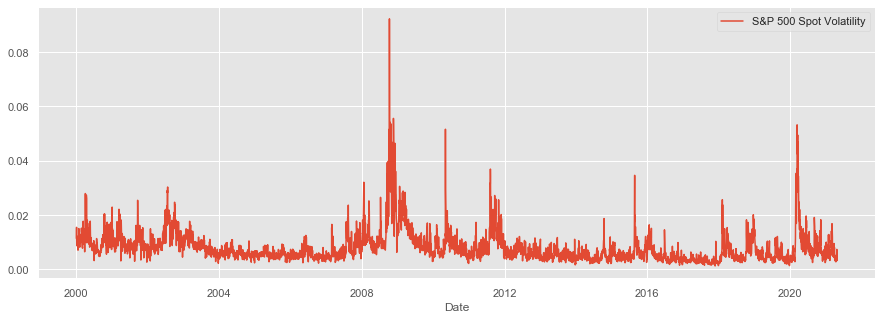

In [2]:
rv1 = rv1.mask(rv1['Symbol'] != '.SPX').dropna()
plt.figure(figsize=(15,5))
plt.plot(rv1.index,np.sqrt(rv1['rk_th2'].values))
plt.xlabel('Date')
plt.legend(['S&P 500 Spot Volatility'])
plt.show()

[*********************100%***********************]  1 of 1 completed


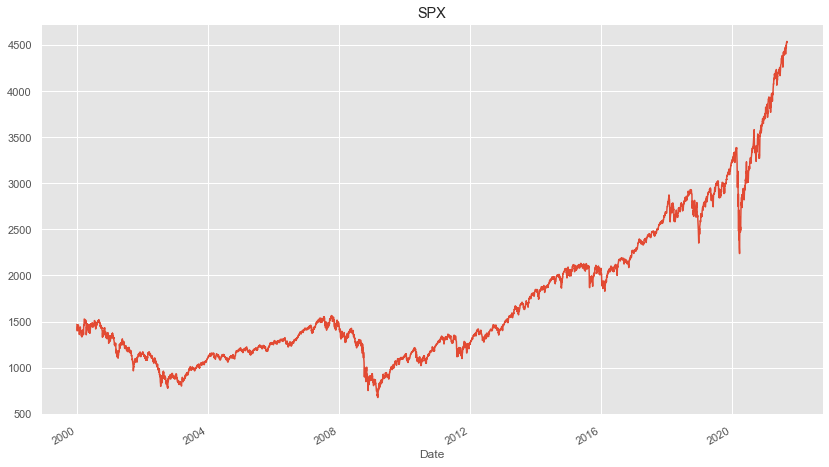

In [3]:
SPX = pd.DataFrame()
SPX = pdr.get_data_yahoo('^GSPC',start='2000-01-01')
SPX = SPX['Adj Close']
SPX.plot(title='SPX',figsize=(14, 8))

# Feating log-moments linearly 

In [4]:
spx = rv1 
spx['sqrt']= np.sqrt(spx['rk_th2'])
spx['log_sqrt'] = np.log(spx['sqrt'])

def del_Raw(q, x): 
    return [np.mean(np.abs(spx['log_sqrt'] - spx['log_sqrt'].shift(lag)) ** q)
            for lag in x]

[0.08397519061943344, 0.16751519336448237, 0.25082211547343497, 0.33409727761003605, 0.4174812303006484, 0.5009887333983499]


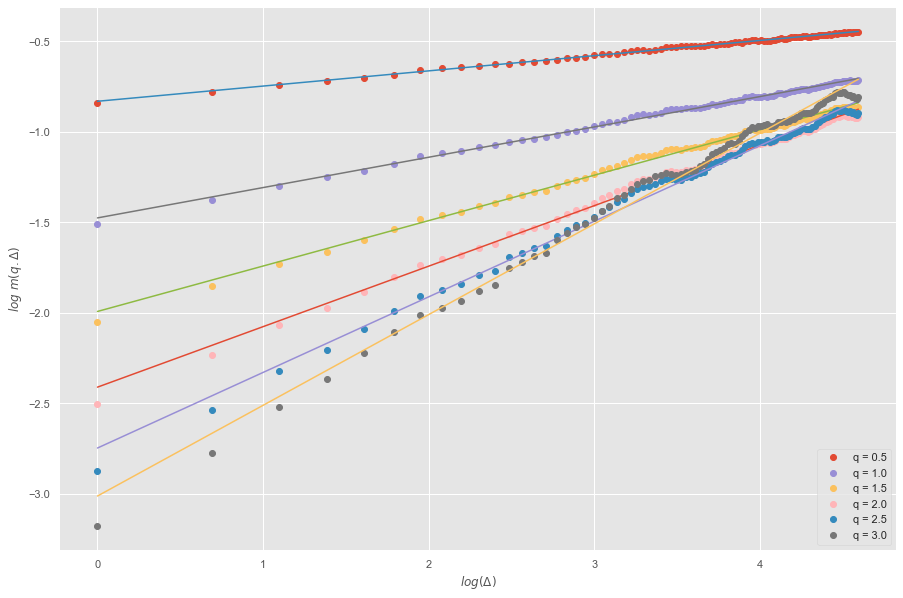

In [5]:
plt.figure(figsize=(15, 10))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 2.5,3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o',label = 'q = {}'.format(q)) 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)),1) 
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
    plt.legend()
    
print(zeta_q)

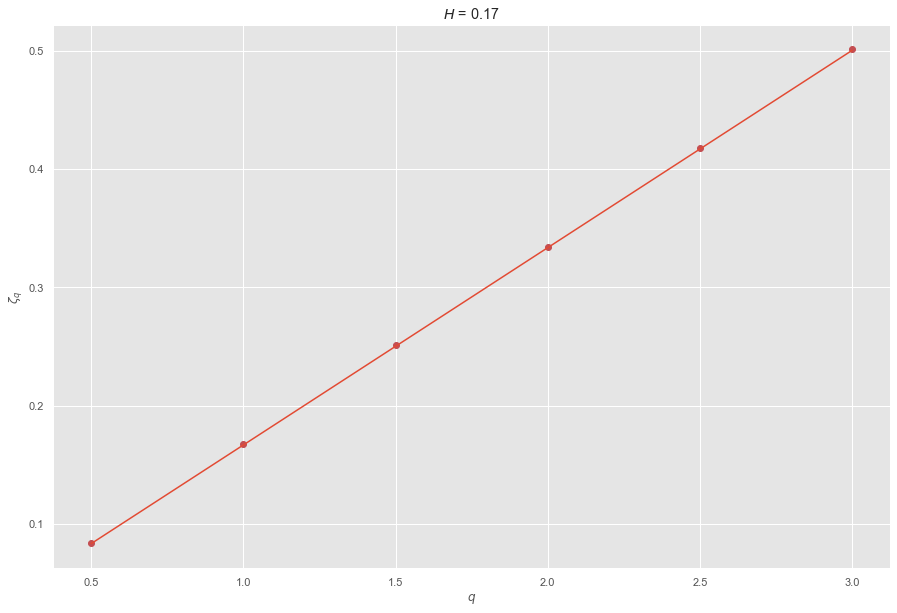

In [6]:
plt.figure(figsize=(15,10))
plt.xlabel(r'$q$')
plt.ylabel(r'$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1,full=True)
plt.plot(qVec, line[0][0] * qVec)
h_est= line[0][0]
MSE = line[1][0]
nu = (np.sqrt(np.exp(model[1])))
plt.title(r'$H$ = {}'.format(h_est.round(2)))
plt.show()

# Distribution of the log increments of the volatility 

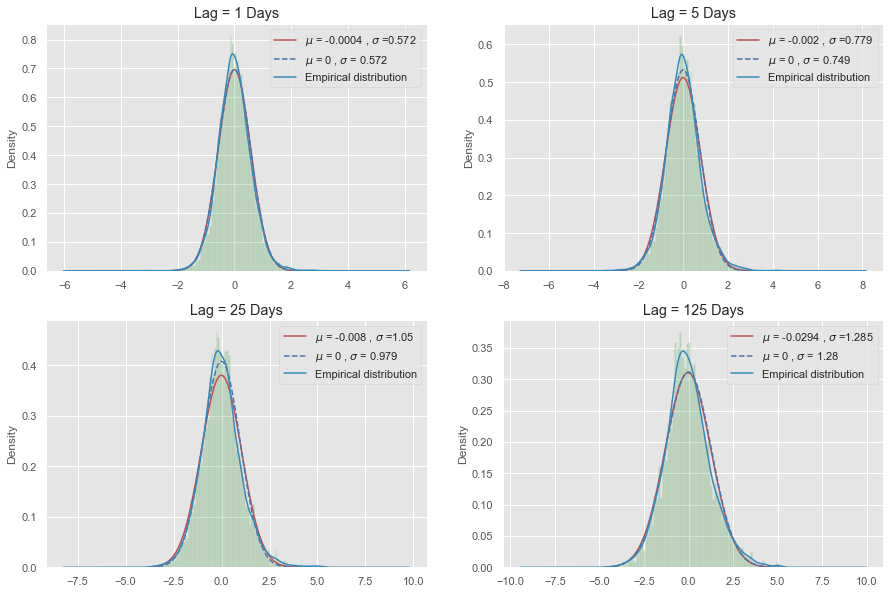

In [7]:

def plotScaling(j, scaleFactor,h_est,qth):
    col_name = rv1.columns[j]
    v = rv1[col_name]
    x = np.arange(1,101)
    
    def xDel(x, lag):
        return (x-x.shift(lag))**qth
    
    def sdl(lag,qth):
        return (xDel(np.log(v), lag)).std()
    
    sd1 = (xDel(np.log(v), 1)).std()
    h = h_est
    f, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(15, 10))
    
    for i_0 in range(0, 2):
        for i_1 in range(0, 2):
            la = scaleFactor ** (i_1*1+i_0*2)
        
            hist_val = xDel(np.log(v), la).dropna()
            std = hist_val.std()
            mean = hist_val.mean()
        
            ax[i_0][i_1].set_title('Lag = %s Days' %la)
            n, bins, patches = ax[i_0][i_1].hist(hist_val.values, bins=100,
                                   normed=1, facecolor='green',alpha=0.2)
            ax[i_0][i_1].plot(bins, norm.pdf(bins, mean, std), "r",label = r'$\mu$ = {} , $\sigma$ ={}'.format(np.round(mean,4),np.round(std,3)))
            ax[i_0][i_1].plot(bins, norm.pdf(bins, 0, sd1 * la ** h), "b--",label = r'$\mu$ = {} , $\sigma$ = {}'.format(0,np.round(sd1 * la ** h,3)))
            hist_val.plot(kind='density', ax=ax[i_0][i_1],label = 'Empirical distribution')
            ax[i_0][i_1].legend()
            
plotScaling(0,5,h_est,1)

In [8]:
def dlsig2(sic, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print(a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

sig = rv1['rk_th2']
sig = np.log(np.sqrt(sig))
sig = sig.dropna()
model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
nu = (np.sqrt(np.exp(model[1])))
h = (model[0]/2.)

In [9]:
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) /(scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h))

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = rvdata.truncate(after=date)
    l = len(rvdata.truncate(after=date))
    ldata = np.log(ldata.iloc[l - nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / np.sum(ldata['cf'])
    return np.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

df = pd.read_csv('/Users/elyes/Desktop/oxfordmanrealizedvolatilityindices copy.csv', index_col=1, header=0 )
rv1 = df['rk_th2']
rv1.index = pd.to_datetime(df.iloc[:,0])
rv1 = pd.DataFrame(rv1)
rv1['Symbol'] = df.index
rv1 = rv1.mask(rv1['Symbol'] != '.SPX').dropna()
rvdata = rv1.drop(['Symbol'],axis = 1)

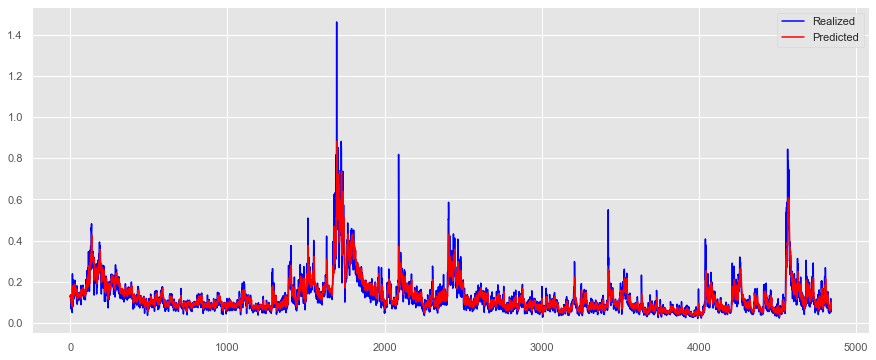

In [10]:
n = len(rvdata)
delta = 1
nLags = 500
dates = rvdata.iloc[nLags:n-delta].index
rv_predict = [forecast_XTS(rvdata, h=h_est, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:n].values
rv_actual.reshape(1,len(rv_actual))
rv_predict = np.array(rv_predict)
plt.figure(figsize=(15, 6))
vol_actual = np.sqrt(rv_actual * 252 ) 
vol_predict = np.sqrt(rv_predict * 252)
plt.plot(vol_actual,color = "blue",label ='Realized')
plt.plot(vol_predict,color = "red",label ='Predicted')
plt.legend()
plt.show()

# Euclidian Norm-Errors give each $\nu$

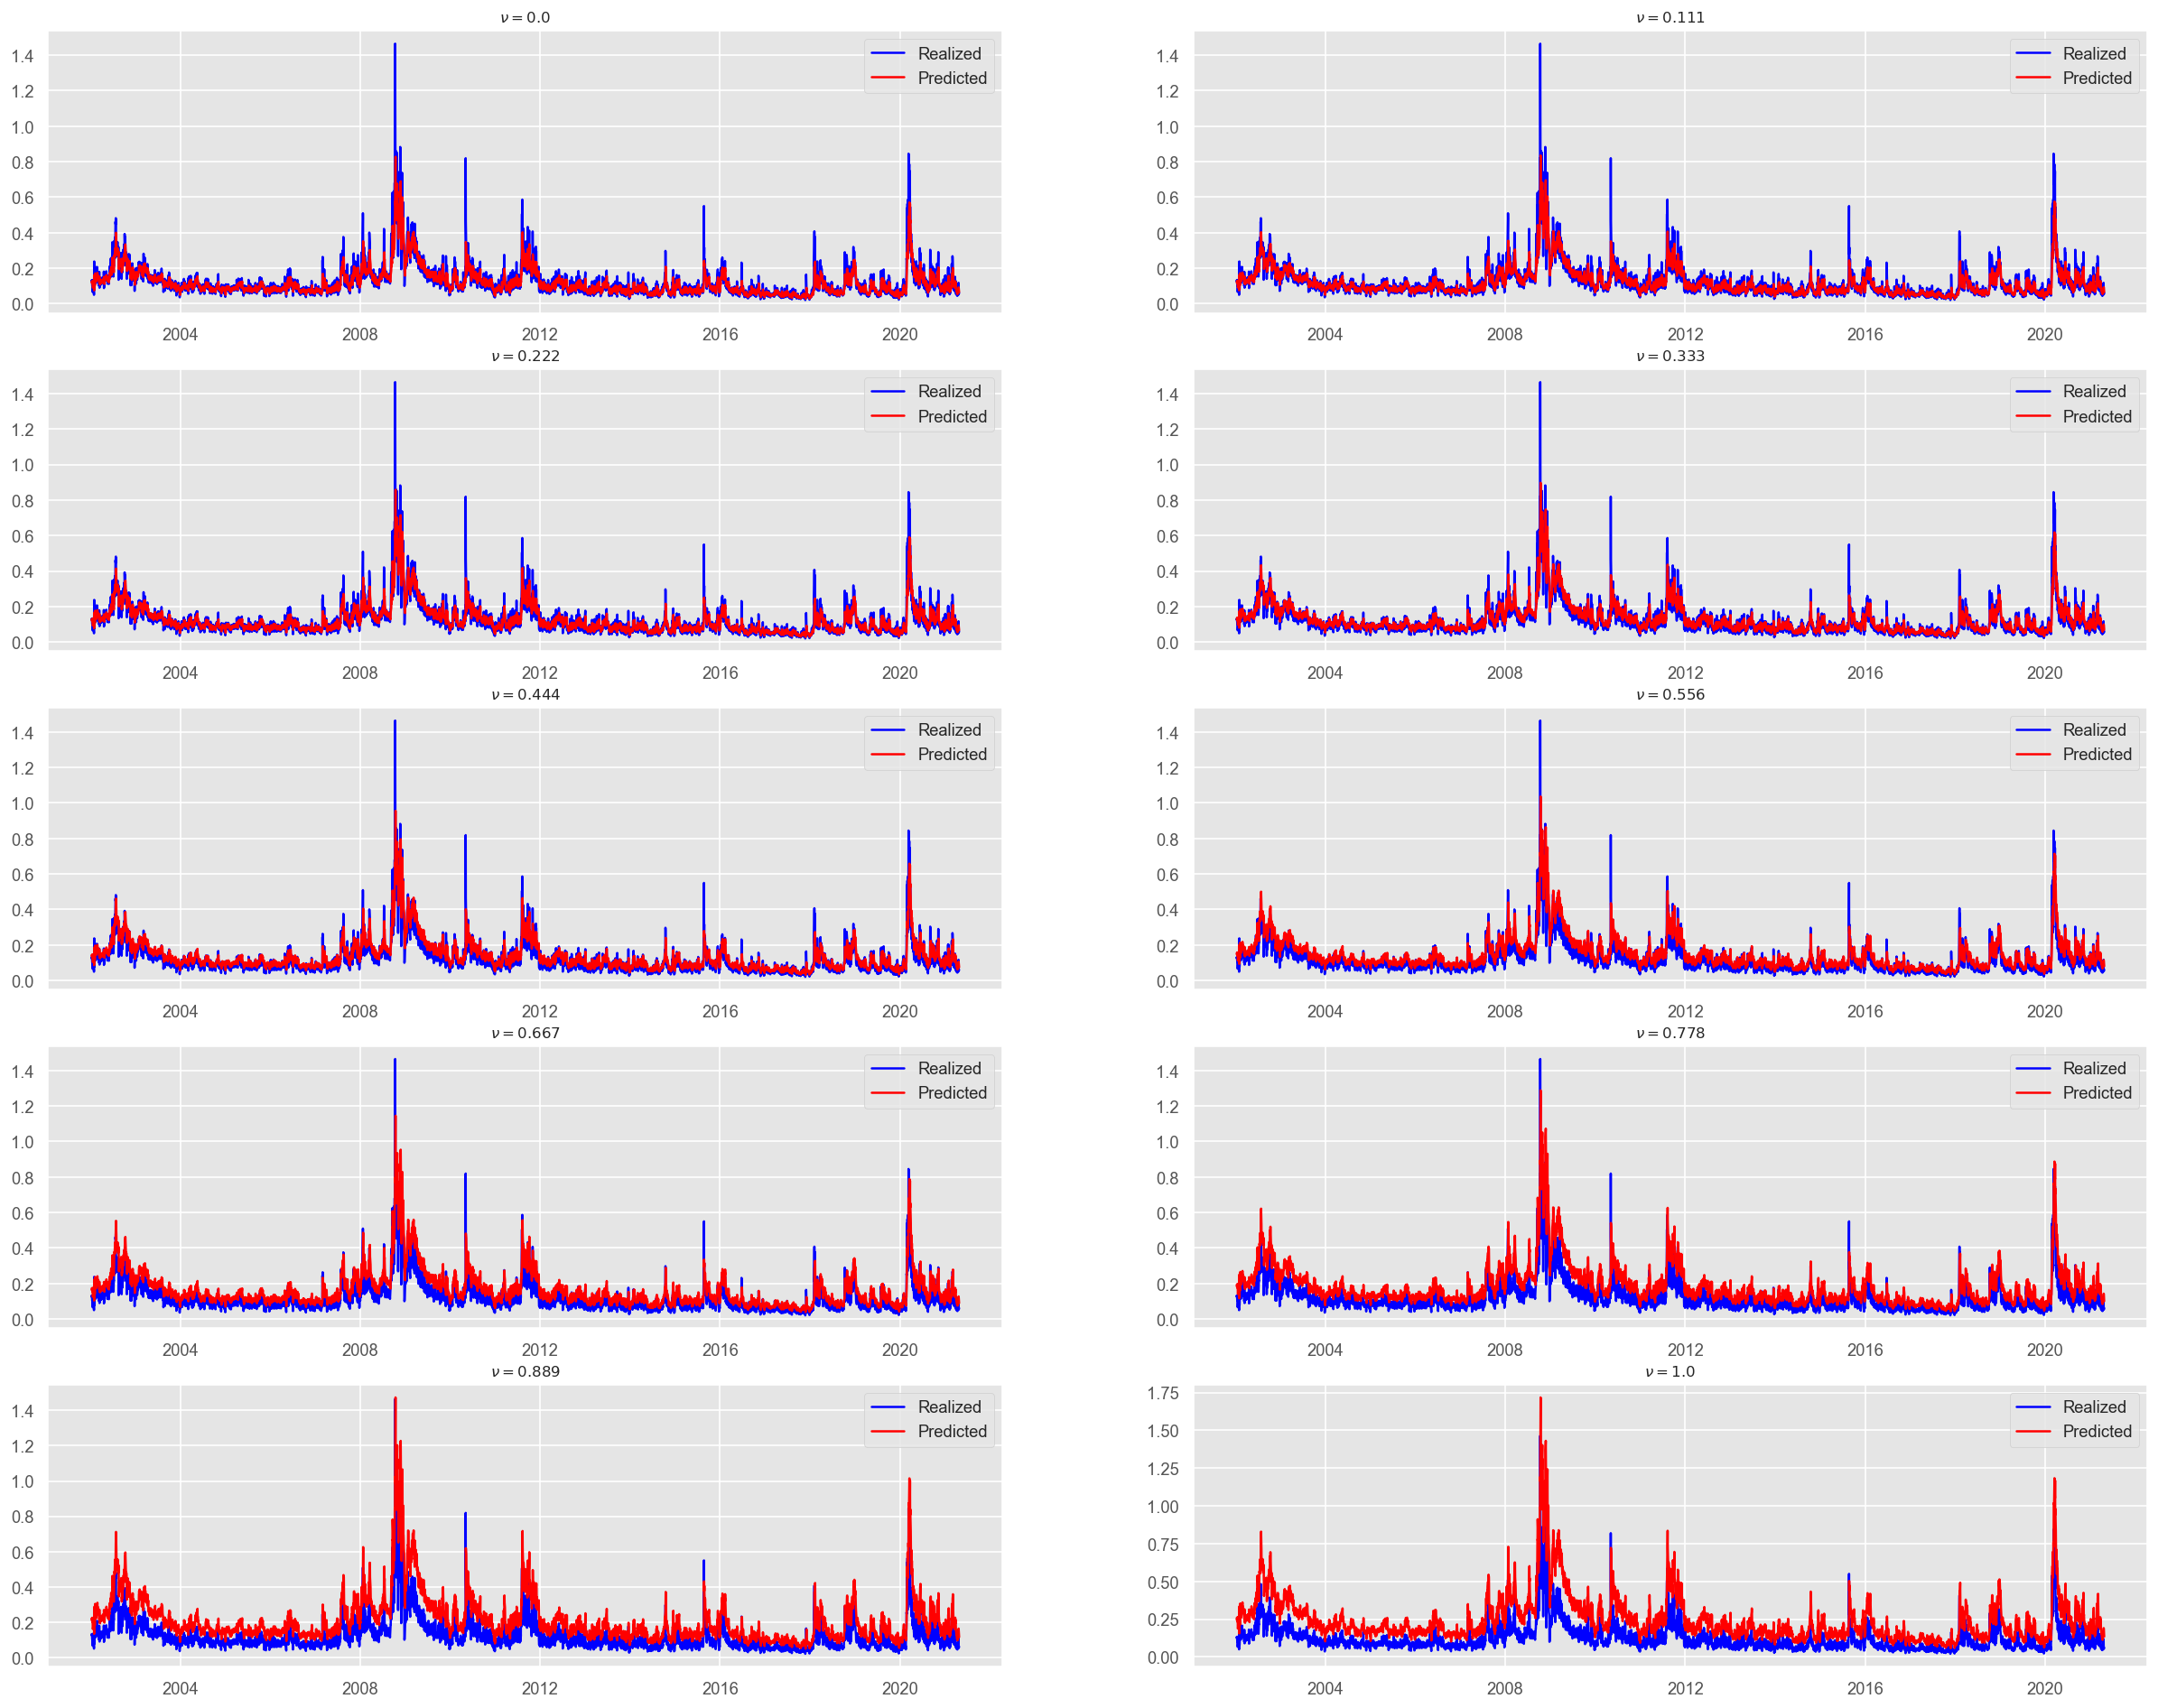

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(25,20))
fig.canvas.set_window_title('Rough Volatility')
errors = {}
G = np.linspace(0,1,10)
for i, ax in enumerate(axes.flatten()): 
    rv_predict = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=G[i]) for d in dates]
    rv_actual = rvdata.iloc[nLags+delta:n].values
    rv_predict = np.array(rv_predict)
    vol_actual = np.sqrt(rv_actual * 252 ) 
    vol_predict = np.sqrt(rv_predict * 252)
    errors[r'$/nu = {}$'.format(round(G[i],3))] = np.sum((vol_actual.reshape(1,len(vol_actual))[0]**2 - vol_predict**2)**2)
    ax.plot(rvdata.index[501:],vol_actual,color = "blue",label ='Realized')
    ax.plot(rvdata.index[501:],vol_predict,color = "red",label ='Predicted')
    ax.legend()
    ax.set_title(r'$\nu = {}$'.format(round(G[i],3)),fontsize=10)
    

# Swap Curve

In [11]:
def xi(date, tt, nu,h, tscale):  # dt=(u-t) is in units of years
    return [forecast_XTS(rvdata,h=h,date=date,nLags=500,delta=dt*tscale,nu=nu) for dt in tt]

def varSwapCurve(date, bigT, nSteps, nu, h, tscale, onFactor):
    # Make vector of fwd variances
    tt = [ i * (bigT) / nSteps for i in range(nSteps+1)]
    delta_t = tt[1]
    xicurve = xi(date, tt, nu, h, tscale)
    xicurve_mid = (np.array(xicurve[0:nSteps]) + np.array(xicurve[1:nSteps+1])) / 2
    xicurve_int = np.cumsum(xicurve_mid) * delta_t
    varcurve1 = np.divide(xicurve_int, np.array(tt[1:]))
    varcurve = np.array([xicurve[0],]+list(varcurve1))
    varcurve = varcurve * onFactor * tscale 
    res = pd.DataFrame({"texp":np.array(tt), "vsQuote": np.sqrt(varcurve)})
    return res

rv1 = df[['rk_th2']]
rv1.index = pd.to_datetime(df.iloc[:,0])
rv1['Symbol'] = df.index
rv1 = rv1.mask(rv1['Symbol'] != '.SPX').dropna()
rvdata = rv1.drop(['Symbol'],axis = 1)

In [12]:
from dateutil.tz import tzutc
from scipy.interpolate import interp1d
from matplotlib.mlab import *
def varSwapForecast(date,tau,nu,h,tscale,onFactor,nSteps):
    vsc = varSwapCurve(date, bigT=tau, nSteps= nSteps, nu=nu, h=h,
                    tscale=tscale, onFactor=onFactor) # Creates the whole curve
    x = vsc['texp']
    y = vsc['vsQuote']
    return np.array(x),np.array(y)

# Test the function
tau = 2.5 
date = dat.datetime(2021,4,16,0,0,tzinfo=tzutc())
x_new,var_swap = varSwapForecast(date,tau,nu=0.10,h=h_est,tscale=252,onFactor=1,nSteps = 1)
var_swap

array([0.06123726, 0.08113394])

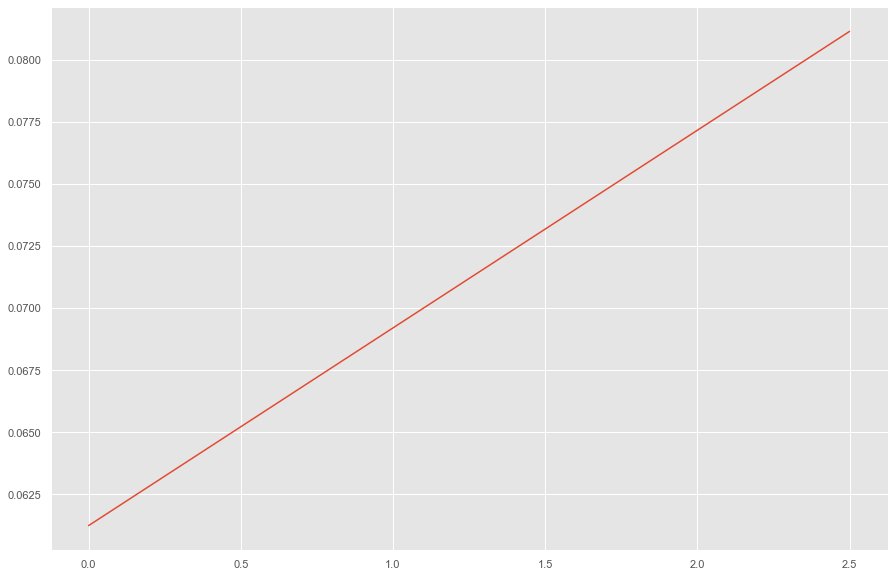

In [13]:
fig = plt.figure(figsize = (15,10))
plt.plot(x_new,var_swap)
plt.show()

# Rough Bergomi Model

In [14]:
import numba 
from numba import jit,njit
import numpy as np
from scipy import linalg

h = h_est
n = len(rvdata)
delta = 1
nLags = 500
dates = rvdata.index[-1]
rv_predict = [forecast_XTS(rvdata, h=h, date=dates, nLags=nLags,
                           delta=delta, nu=nu)]
rv_actual = rvdata.iloc[nLags+delta:n].values
rv_actual.reshape(1,len(rv_actual))
rv_predict = np.array(rv_predict)

In [54]:
@njit(parallel=True)
def Rough_Bergomi_model(dt,strike,spot,rate,N,T,
                        rho,w_,e,h,nu,swap_t0,rnd,
                        drift):

    callT = np.zeros(N)

    expiry = T/252 

    dW = np.zeros((N,int(T)))

    V = np.ones((N,int(T))) * swap_t0
    
    V[:,0] = swap_t0 

    S_path = np.ones((N,int(T)))

    S_path[:,0] = spot 

    W = ( rho * (  e[:,1:] - e[:,:-1]  ) + np.sqrt( 1 - rho ** 2 ) * ( rnd[:,1:] - rnd[:,:-1] ) )

    for i in numba.prange(0 , N ) :

        for j in numba.prange( 1 , T ) :

            #Simulate Brownian Motion first

            dW[ i , j ]  =  W[ i , j - 1 ]  
            
            #Integrate (Discretely) Over paths 
            
            ft = nu * np.sum( w_[ i , 1 : j ] - w_[ i , : j - 1] )  
            
            #Second Term 
            
            st = - ( .5 * ( nu ** 2 ) * ( dt * j ) ** ( 2 * h ) )
            
            #Generate Variance Process 
            
            V[i, j] = swap_t0 * np.exp( ft + st )
            
            #Generate Full Variance Paths

            returns = np.exp( ( drift - .5 * V[i,j]) * dt + np.sqrt( V[i,j]) * dW[i,j] )
            
            S_path[i,j] = S_path[ i,j - 1 ] * returns 

    callT = np.maximum(S_path[:,-1] - strike, 0.0)
      
    callT = np.mean(callT) * np.exp(-rate * expiry) 

    return V , callT,S_path,dW

In [16]:
drift = 0.03/100 - 1.45/100
@njit(parallel=True)
def autocov(t1,t2,empty_mt,n,H):
    for m in numba.prange(n) :
        l = t2[m] 
        for i in numba.prange(n) : 
            x = t1[i]
            empty_mt[i,m] = .5 * (x**(2*H) + l**(2*H) - np.abs(x-l)**(2*H))
    return empty_mt

@njit(parallel=True)
def Generate_MC(Lower_mt,rnd,M,arr):
    for i in numba.prange(0,M):
        arr[i,:] = Lower_mt @ rnd[i,:]
    return arr

h_est = 0.10
def Data_Prep(N,daysr,h,e,t1,t2):
    empty_mt = np.zeros((daysr,daysr))
    df = autocov(t1,t2,empty_mt,len(t2),h)
    Lower_mt = linalg.cholesky( df , lower=True )
    arr = np.ones((N,daysr)).reshape(N,daysr)
    b = Generate_MC(Lower_mt,e,N,arr)
    return b

In [17]:
N = 30000
daysr = int(np.round(252*3,0))
arr = np.ones((N,daysr)).reshape(N,daysr)
t1 = np.linspace(1/252,int(daysr/252),daysr)
t2 = np.linspace(1/252,int(daysr/252),daysr)
e = np.random.normal(size=( N , daysr ) )

In [18]:
%%time
e_ = Data_Prep(N,daysr,h_est,e,t1,t2)

CPU times: user 12.6 s, sys: 8.02 s, total: 20.6 s
Wall time: 3.55 s


In [19]:
%%time
S0 = 5000
N = int(e_.shape[0])
eta = 2
xi_0 = 0.0196
rnd = np.cumsum(np.random.normal(size=( N , daysr )) * np.sqrt(1/252),axis = 1 )
W2 = np.cumsum(e[:,:] * np.sqrt(1/252),axis = 1)
P,C,Spa,DW = Rough_Bergomi_model( 1/252 , S0 , S0 , 0 , N , daysr , -0.90 ,e_[:,:], W2, \
                                 h_est , eta , xi_0 , rnd,drift )
print('Number of iterations : {}'.format( N ) + ' Bergomi Price : ' + str(C) )

Number of iterations : 30000 Bergomi Price : 3.0721154881563524
CPU times: user 17 s, sys: 1.2 s, total: 18.2 s
Wall time: 6.53 s


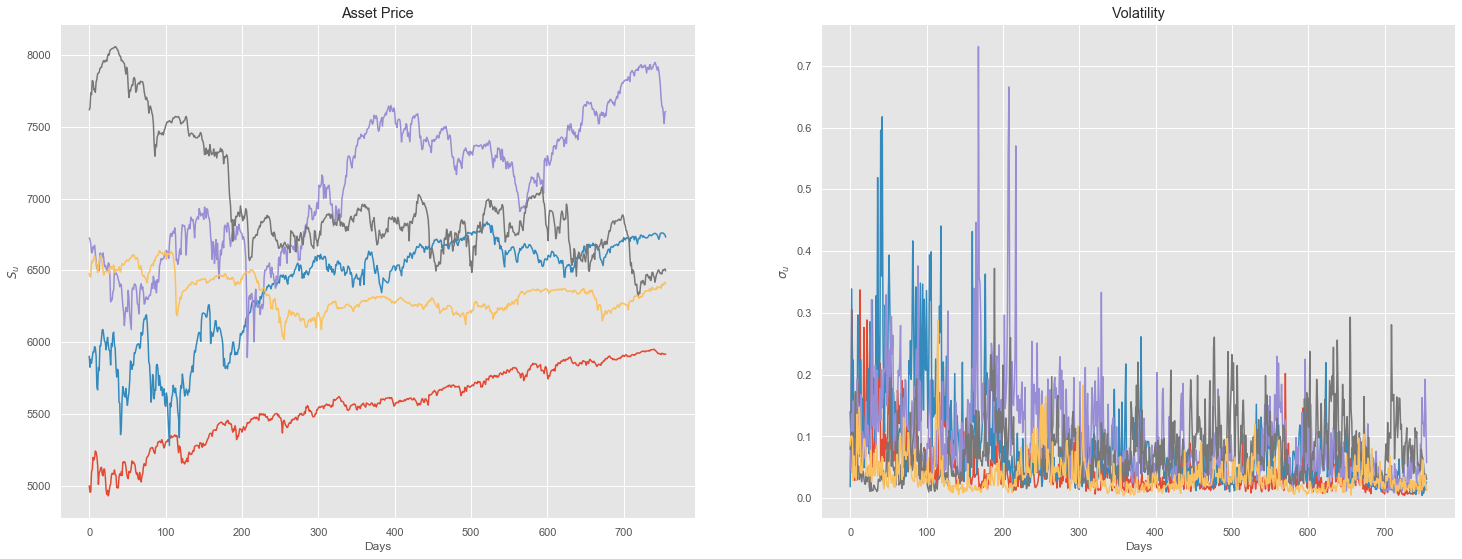

In [20]:
plt.figure(figsize=(25,20))
plt.subplot(221)
plt.plot(Spa.T[:,:5])
plt.title('Asset Price')
plt.xlabel('Days')
plt.ylabel(r'$S_{u}$')
plt.subplot(222)
plt.plot(np.sqrt(P.T[:,:5]))
plt.title('Volatility')
plt.xlabel('Days')
plt.ylabel(r'$\sigma_u$')
plt.show()

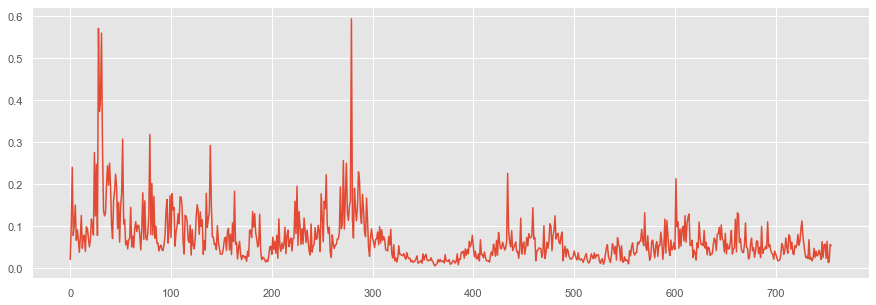

In [21]:
figure = plt.figure(figsize=(15,5))
plt.plot(np.sqrt(P.T[:,21]))
plt.show()

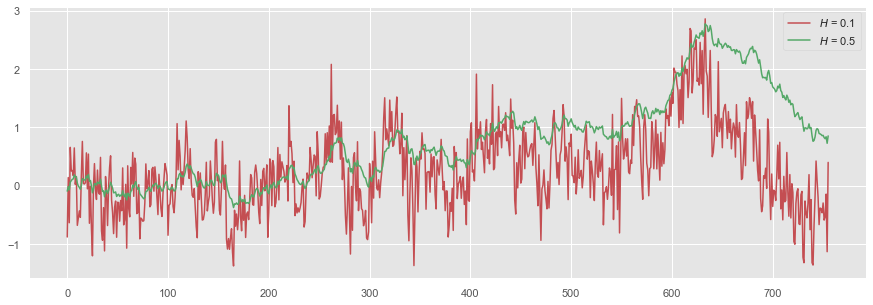

In [22]:
fig = plt.figure(figsize = (15,5))
plt.plot(e_[-100],label = '$H$ = {}'.format(np.round(h_est,2)),color = 'r')
plt.plot(np.cumsum(np.sqrt(1/252)*e[-100]),label = '$H$ = 0.5',color = 'g')
plt.legend()
plt.show()

# Why doesn't the Comte Model works

In [23]:
def del_Raw2(x,kappa,sigma_0,nu) :
    A = [ (np.exp(- kappa * lag) - 1 )**2 * (np.log(sigma_0))**2 +\
           nu**2 * (1 - np.exp(-2 * kappa * lag))/(2 * kappa)\
                   for lag in x]  
    return A 

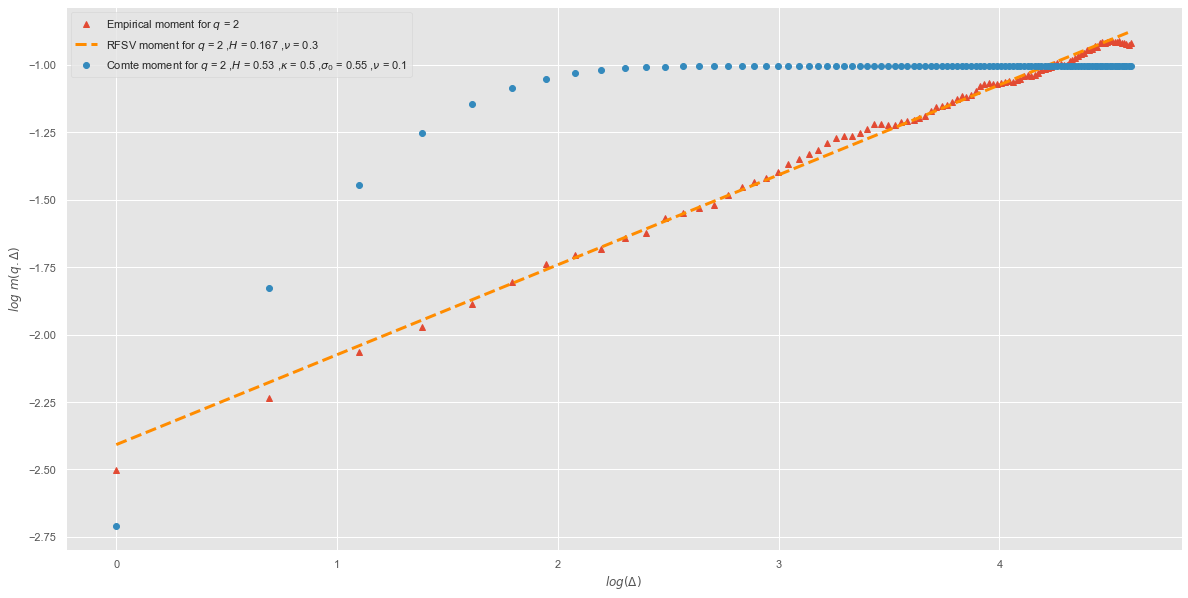

In [24]:
plt.figure(figsize=(20, 10))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim = (-3, -.5)

zeta_q = list()
qVec = np.array([2])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x),np.log(del_Raw(q, x)),'^',label = 'Empirical moment for $q$ = {}'.format(q))
    plt.plot(np.log(x),np.log( 0.09 * x ** ( 2 * 0.1667 ) ),'--',\
             label = r'RFSV moment for $q$ = {} ,$H$ = {} ,$\nu$ = {}'.format(\
                     q,0.167,np.sqrt(0.09)),linewidth=3.0 , c = 'darkorange')
    plt.plot(np.log(x),np.log(del_Raw2(x,0.53,0.55,.1)),'o',\
        label = r'Comte moment for $q$ = {} ,$H$ = {} ,$\kappa$ = {} ,$\sigma_0$ = {} ,$\nu$ = {}'.format(\
                q,0.53,0.5,0.55,0.1))
    zeta_q.append(model[0])
    plt.legend()

# Comparaison with Stochastic Vols

In [25]:
%%time
import numpy as np

def callTPayoff(spot, strike):
    return np.maximum(spot - strike, 0.0)

spot = 4180.50
strike = 4180.50
expiry = 3
rate = 0.03/100
vol = xi_0#round((0.20)**2,3)
div = 1.45/100
kappa = 4
theta = round((0.20)**2,3)
sigma = 0.3
rho = -0.9

print('feller cond satisfied ? : {}'.format(2*kappa*theta - sigma**2 > 0))

M = 3000 # number of replications
N = int(round(252 * expiry,0))  # number of steps

dt = 1 / 252

path = np.zeros(N)
var = np.zeros(N)
callT = np.zeros(M)
e_1 = Data_Prep(M,daysr,0.50,e,t1,t2) 
e_2 = Data_Prep(M,daysr,0.50,( rnd[:,1:] - rnd[:,:-1] )/np.sqrt(dt),t1,t2)
z1 = ( e_1[:,1:] - e_1[:,:-1] )/ np.sqrt(dt)
z2 = rho * ( e_2[:,1:] - e_2[:,:-1] )/ np.sqrt(dt) + np.sqrt( 1 - rho**2 ) * ( z1 )

feller cond satisfied ? : True
CPU times: user 1.93 s, sys: 1.02 s, total: 2.95 s
Wall time: 432 ms


In [26]:
%%time
@jit(nopython=True, parallel=False,fastmath=True)
def Heston_computator(vol,kappa,theta,sigma,path,var,\
                      callT,z1,z2,strike,spot,rate,\
                      expiry,dt):
    
    var = np.zeros((M,N))
    path = np.zeros((M,N))
    var[:,0] = vol
    path[:,0] = spot
    for i in numba.prange(0,M):
        for j in numba.prange(1,N):
            #simulate variance equation first
            var[i,j] = var[i,j-1] + kappa * (theta - var[i,j-1]) * dt + sigma * np.sqrt(var[i,j-1] * dt) * z2[i,j]
            path[i,j] = path[i,j-1] * np.exp((rate - div - 0.5 * var[i,j]) * dt + np.sqrt(var[i,j] * dt) * z1[i,j])
        callT[i] =  np.maximum(path[i,-1] - strike, 0.0 )
    callT = np.mean(callT) * np.exp(-rate * expiry) 
    return callT,path,var

rm,Sp,Vr = Heston_computator(vol,kappa,theta,sigma,path,\
                             var,callT,z1,z2,strike,spot,rate,\
                             expiry,dt)
result = rm
IT = M*N
fmt = "The value of the callT option is: {0:0.3f} with {1} iterations!!"
print(fmt.format(result,IT))

The value of the callT option is: 1009.566 with 2268000 iterations!!
CPU times: user 542 ms, sys: 14.6 ms, total: 556 ms
Wall time: 558 ms


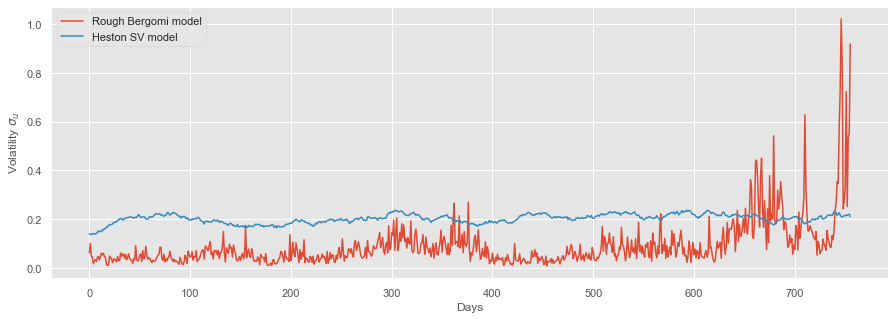

In [27]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.sqrt(P.T[:,-2]))
plt.plot(np.sqrt(Vr.T[:,-2]))
plt.legend(['Rough Bergomi model','Heston SV model'])
plt.xlabel('Days')
plt.ylabel(r'Volatility $\sigma_u$')
plt.show()

# The Mono factorial Bergomi Model

In [28]:
n = 1
Interval = np.ones(n*252)/252#np.linspace(1/252,6,6*252)
Interval2 = np.cumsum(np.ones(n*252)/252)
Z = np.random.normal(0,1,(100,Interval.size))
w,w_1 = 0.01,0.10
k = 1;T = n
Riemman_sum_1 = np.cumsum((w*np.exp(-k*(Interval2-Interval)) * Z * (1/252)**(1/2)).T,axis=0)
Riemman_sum_2 = np.cumsum((w**2 *(1 - np.exp(-2 * k * (Interval2)))/(2 * k)).T,axis=0)
Riemman_sum_3 = np.exp(np.exp(-k*(T-Interval2))*Riemman_sum_1.T - \
                             .5 * np.exp(-2*k*(T-Interval2)) * Riemman_sum_2 )

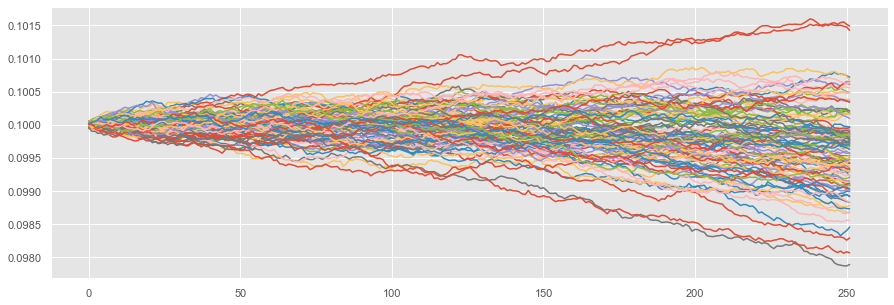

In [29]:
cm = w_1 * Riemman_sum_3.T
fig = plt.figure(figsize = (15,5))
plt.plot(cm)
plt.show()

# Evaluation of The Volatility Skew

In [30]:
import datetime 
L = pd.read_excel('/Users/elyes/Desktop/df_16_04_21.xlsx')
L.index = L['OPTION EXPIRY DATE']
L = L.drop(columns='OPTION EXPIRY DATE')

In [34]:
from datetime import date as dat
from scipy.stats import norm
from scipy.optimize import brentq
def implied_volatility(price_ ,S, K, T, r):
    args = [price_,S, K, T, r]
    try:
        res = brentq(Optimisor,0.0001,1000,args,maxiter=10000)
    except :
        res = np.nan
    return res

def _price_(S, K, T, r, v):
    d1 = (np.log(S/K) + (r + 0.5 * v ** 2) * T)/(v * T**(1/2))
    d2 = d1 - v * T **(1/2)
    Option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return Option_price

def Optimisor(x,args):
    price_,S, K, T, r = args
    A = _price_(S, K, T, r, x)
    MNM = A - price_
    return MNM

L.iloc[:,1] = L.iloc[:,1]
L.iloc[:,2] = L.iloc[:,2]
L['Spread'] = abs(L.iloc[:,1] - L.iloc[:,2])
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2 
L.sort_index(inplace = True)
L = L.mask(L.Strikes > 4551).dropna()
Date_16_4_21 = pd.to_datetime(dat(2021, 4, 16))
L['TTM'] =  (L.index - Date_16_4_21).days/360
S0 = 4180.50

In [36]:
IV = {}
r = 0.03/100
q = 1.45/100
drift = r-q
for i in range(0,len(L)):
    IVO = implied_volatility(L['Mid Price'].iloc[i],4180.50,L['Strikes'].iloc[i],L['TTM'].iloc[i],drift)
    IV[i] = IVO
IV = pd.DataFrame(IV.values(),index = IV.keys())
L['Implied Volatility'] = IV.values
imp_vol = IV.values
spreads = L.Spread.values
Q = L.groupby(['TTM','Strikes']).mean()
Q

IV   Bid     Ask  Spread  Mid Price  Implied Volatility
TTM      Strikes                                                             
0.097222 3250.0   0.3571  924.3  931.1     6.8     927.70            0.355634
         3350.0   0.3329  824.9  831.7     6.8     828.30            0.333990
         3450.0   0.3083  725.7  732.6     6.9     729.15            0.310947
         3550.0   0.2903  628.0  633.9     5.9     630.95            0.292970
         3650.0   0.2388  528.8  535.5     6.7     532.15            0.262120
...                  ...    ...    ...     ...        ...                 ...
2.702778 4150.0   0.2006  468.8  516.8    48.0     492.80            0.200646
         4250.0   0.1953  415.4  463.4    48.0     439.40            0.195719
         4350.0   0.1902  365.3  413.3    48.0     389.30            0.190943
         4450.0   0.1854  318.7  366.7    48.0     342.70            0.186358
         4550.0   0.1809  275.9  323.9    48.0     299.90            0.182056

[210 rows x 6 columns]

In [39]:
from scipy.linalg import circulant,eigvals,eig,inv
import numpy as np 

def autocovG(H,n,t):
    empty_mt = np.zeros(2 * (n-1))
    inverse_incremant = n/t
    for m in range(n + 1):
        empty_mt[m] = (np.abs((m-1)/inverse_incremant)**(2*H) - 2 * np.abs(m/inverse_incremant)**(2*H) \
                       + np.abs((m+1)/inverse_incremant)**(2*H))*0.5
    empty_mt[n:] = empty_mt[1:n-1][::-1]
    return empty_mt

#Generate Gaussian Noise Using FFT
def RoughBrownian(H,n,t,simuln):
    cov_mtx = autocovG(H,n,t)
    Z = np.random.default_rng().normal(0,1,size=(simuln,cov_mtx.shape[0]))
    Gaussian_Noise = (np.fft.ifft(np.sqrt(np.fft.fft(cov_mtx))*Z, norm='ortho').real)
    return np.cumsum(Gaussian_Noise,axis=1)[:,:n],Z[:,:n]

simuln = 30000
#t = L.TTM.max() 
#n = int(np.round(t * 252,0)) * 3
#H_est = 0.10
#W_H,Z_1 = RoughBrownian(H_est,n,t,simuln)
#Z_2 = np.random.default_rng().normal(0,1,size=(simuln,Z_1.shape[1]))
#Using Cholesky Decomposition 
n = int(np.round(252*3,0))
Z_1 = np.random.default_rng().normal(0,1,size=(simuln,n))
Z_2 = np.random.default_rng().normal(0,1,size=(simuln,n))
W_H = Data_Prep(simuln,n,H_est,Z_1,t1,t2)

In [48]:
dt = 1/252
K = S0
S = S0
H,rho,nu,xi_0 = H_est,-0.9, 1.5,0.01

In [55]:
ZN1,ZN2,ZN3,ZN4 = Rough_Bergomi_model(dt , S0 , S0 , r , simuln , n ,
                        rho,W_H[:,:],np.cumsum(Z_1*np.sqrt(dt),axis=1),H, nu , 
                        xi_0 , np.cumsum(Z_2*np.sqrt(dt),axis=1),drift)
ZN2

125.96736271868747

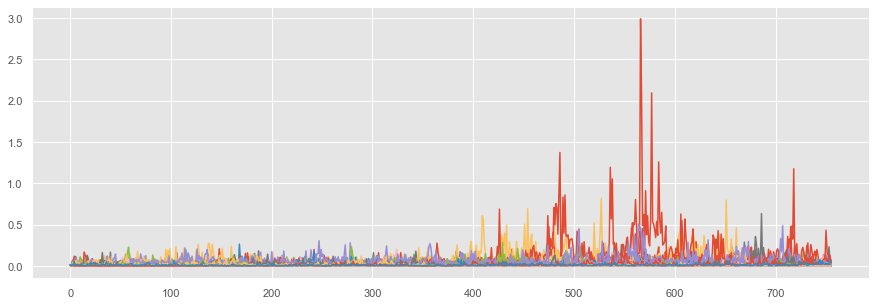

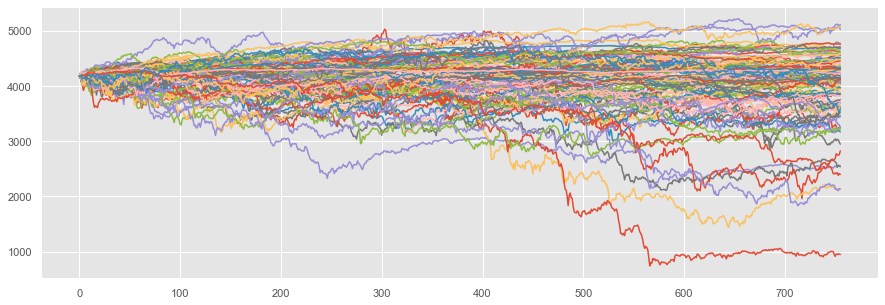

In [57]:
fig = plt.figure(figsize=(15,5))
plt.plot(ZN1.T[:,:100])
plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(ZN3.T[:,:100])
plt.show()

In [97]:
from scipy.optimize import minimize

strikes = np.array(L.Strikes.sort_values().unique())

def Calibration(X,args):
    
    H,nu,rho,xi_0 = X

    dt,strikes,S,drift,Z_2,impvol,spread,simuln,n,Z_1,t,r = args
    
    dayr = int(252*3)
    
    W_H = Data_Prep(simuln,dayr,H,Z_1,t1,t2)

    S_array = Rough_Bergomi_model( dt , S , S , r , simuln , n , rho,
                                      W_H, np.cumsum(Z_1*np.sqrt(dt),axis=1), H , nu , 
                                      xi_0 , np.cumsum(Z_2*np.sqrt(dt),axis=1) , drift )[2]
    
    C_array = np.array([np.mean(np.maximum(S_array[:,-1] - K,0)) for K in strikes])

    
    sigma_ = np.nan_to_num(np.array([implied_volatility(C_array[j],S, K, t , drift)\
                                     for j,K in enumerate(strikes)]), nan = 1e30)
    
    IVMSE = np.sum((spread) * (sigma_ - impvol)**2)/np.sum(spread)
    
    return IVMSE

In [92]:
%%time

np.random.seed(0)

dt = 1/252

X0 = 0.10,2.5,-0.8,0.01

tau = L.TTM.min()

n = int(np.round(tau * 252,0))

t = tau

r = 0.03/100 

spreads = Q.loc[tau].Spread.values

impvol = Q.loc[tau]['Implied Volatility'].values

args = [dt,strikes,S0,drift,Z_2,impvol,
       spreads,simuln,n,Z_1,t,r]

CPU times: user 1.22 ms, sys: 253 µs, total: 1.47 ms
Wall time: 1.25 ms


In [93]:
%%time 
X0 = 0.10,2.5,-0.90,0.03
Calibration(X0,args)

4.0335520109089815e-05
CPU times: user 11.3 s, sys: 8.74 s, total: 20.1 s
Wall time: 2.36 s


4.0335520109089815e-05

In [94]:
strikes = np.array(L.Strikes.sort_values().unique())

def Simulator(dt,H,nu,rho,t,simuln,
              n,Z_2,strikes,drift,
              Z_1,S,r,xi_0):
    
    dayr = int(252*3)
    
    W_H = Data_Prep(simuln,dayr,H,Z_1,t1,t2)#[:,:n]
    
    S_array = Rough_Bergomi_model( dt , S , S , r , simuln , n , rho,
                                      W_H,np.cumsum(Z_1*np.sqrt(dt),axis=1), H , nu , 
                                      xi_0 , np.cumsum(Z_2*np.sqrt(dt),axis=1) , drift )[2]
    
    C_array = np.array([np.mean(np.maximum(S_array[:,-1] - K,0)) for K in strikes])
    
    sigma_ = np.nan_to_num(np.array([implied_volatility(C_array[j],S, K, t , drift)\
                                     for j,K in enumerate(strikes)]), nan = 1e30)
    
    return sigma_

In [95]:
H,nu,rho,xi_0 = 0.10,2.5,-0.90,0.03
Simulator(dt,H,nu,rho,t,simuln,
              n,Z_2,strikes,drift,
              Z_1,S,r,xi_0)

array([0.36647326, 0.34272372, 0.31810786, 0.2932651 , 0.26809372,
       0.24232981, 0.21557667, 0.18758933, 0.15908679, 0.12947005,
       0.10480116, 0.10312801, 0.11265114, 0.12506556])

CPU times: user 44min 25s, sys: 35min 22s, total: 1h 19min 47s
Wall time: 8min 36s


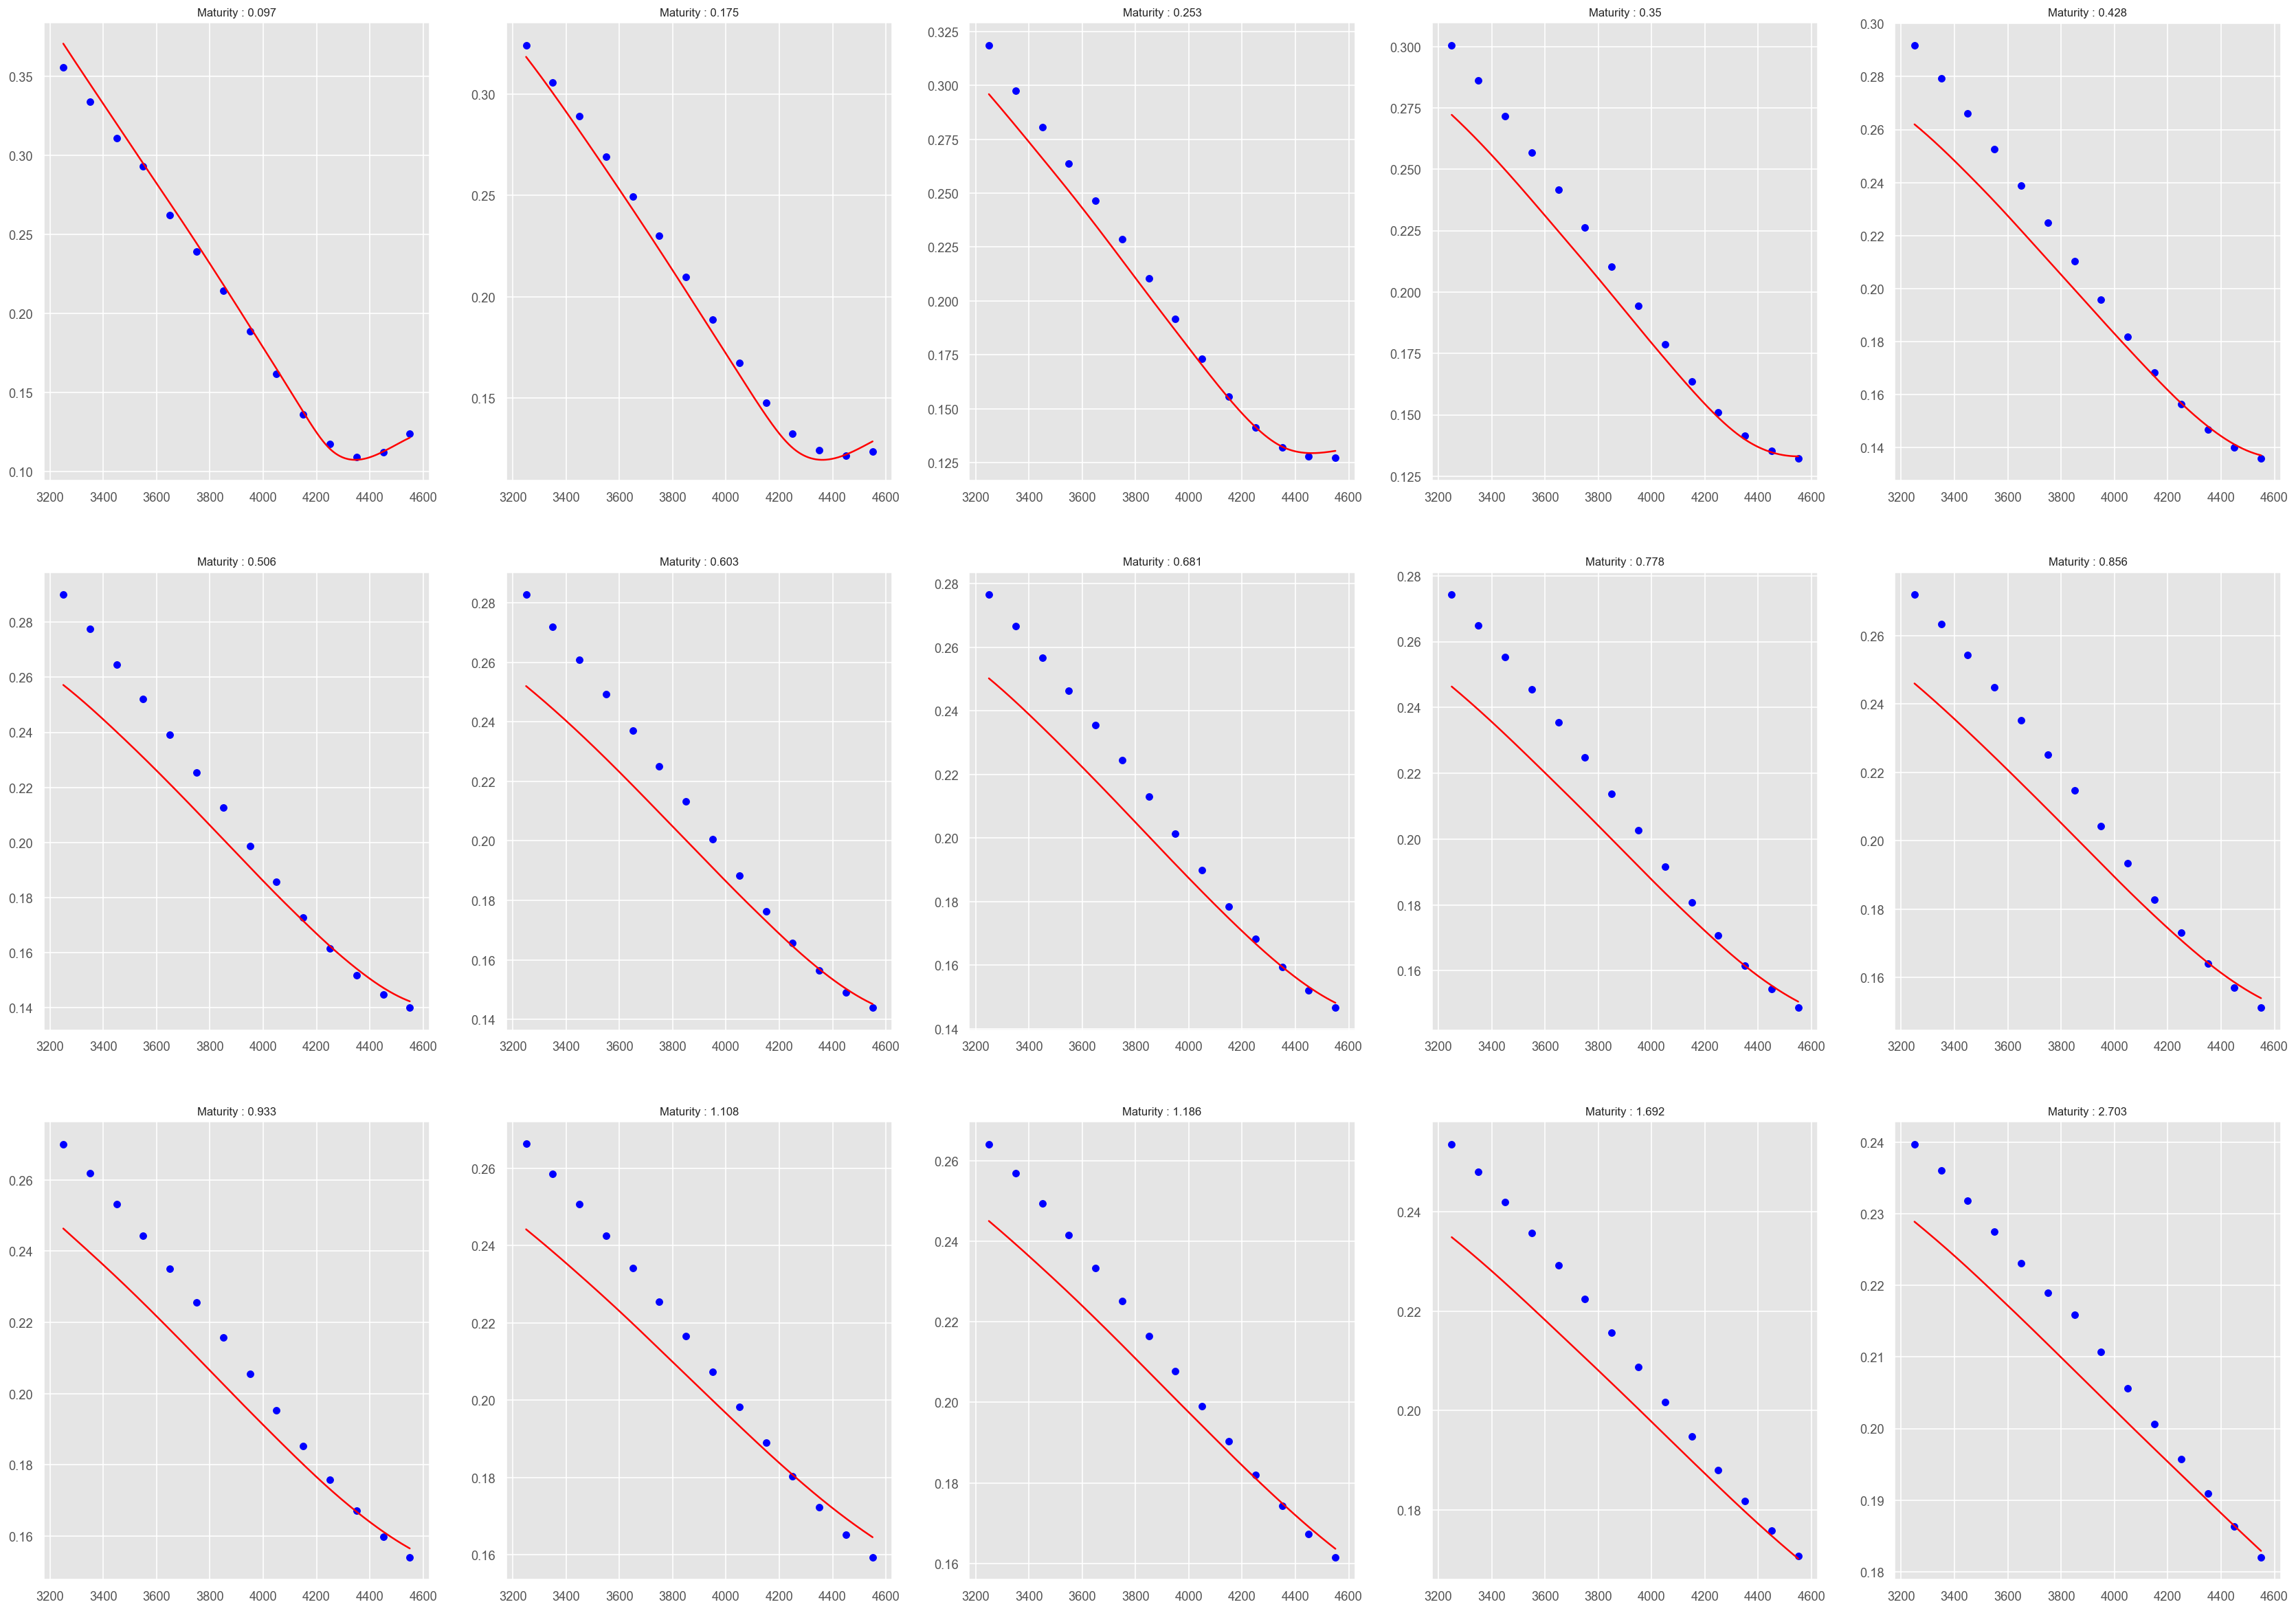

In [98]:
%%time
from scipy.optimize import differential_evolution
from scipy import interpolate

fig, axes = plt.subplots(nrows=3, ncols=5, dpi=120, figsize=(35,25))

strikes = np.array(L.Strikes.sort_values().unique())

stk_n = np.linspace(strikes.min(),strikes.max(),700)

sigma = {}

Params = {}

err = {}

X0 = 0.12862145,  2.41771273, -0.82471362,  0.03070543 #0.10996324,  2.17341928, -0.8711244 ,  0.02095894

for i, ax in enumerate(axes.flatten()):
    
    bnds = ((0.05,0.30),(1.5,3.5),(-1,0))
    
    t = L.TTM.sort_values().unique()[i]
    
    n = int(np.round(t * 252,0))
    
    IV = Q.loc[t]['Implied Volatility'].values
    
    args = [dt,strikes,S0,drift,Z_2,IV,
            1/spreads,simuln,n,Z_1,t,r]
    
    #res = differential_evolution(Calibration,args = [args],
    #                             bounds = bnds,maxiter = 5,seed = 1,
    #                             tol = 1e-6,polish = True)
    
    res = minimize(Calibration,X0, method='Nelder-Mead',args = args , bounds = bnds,\
                   options = {'maxiter' : 5},tol = 1e-9)
    
    
    Params[i] = res.x
    
    err[i] = res.fun 
    
    X0 = res.x
    
    H,nu,rho,xi_0 = Params.get(i)
    
    X0 = H,nu,rho,xi_0
    
    err[i] = Calibration(X0,args)
    
    sigma[i] = Simulator(dt,H,nu,rho,t,simuln,
                         n,Z_2,strikes,drift,
                         Z_1,S0,r,xi_0)
    
    Implied_vol_params = sigma.get(i)
    
    f = interpolate.interp1d(strikes, Implied_vol_params,kind='cubic')
    
    Implied_vol_params = f(stk_n)
    
    ax.plot(stk_n,Implied_vol_params,color = 'red')
    
    ax.scatter(strikes,IV,color = 'blue')
    
    ax.set_title('Maturity : {}'.format(t.round(3),),fontsize=10)

In [99]:
Params

{0: array([ 0.13092477,  2.45156425, -0.83585813,  0.03029612]),
 1: array([ 0.13368646,  2.46497124, -0.72615175,  0.03377544]),
 2: array([ 0.14684622,  2.18766198, -0.72955558,  0.03710022]),
 3: array([ 0.156483  ,  2.02358733, -0.73183544,  0.03953492]),
 4: array([ 0.16235112,  1.8212286 , -0.75927927,  0.04101748]),
 5: array([ 0.17148337,  1.75293252, -0.75453378,  0.04332471]),
 6: array([ 0.17148337,  1.75293252, -0.75453378,  0.04549094]),
 7: array([ 0.17148337,  1.75293252, -0.75453378,  0.04776549]),
 8: array([ 0.17148337,  1.75293252, -0.75453378,  0.05015377]),
 9: array([ 0.17148337,  1.75293252, -0.75453378,  0.05266145]),
 10: array([ 0.17148337,  1.75293252, -0.75453378,  0.05529453]),
 11: array([ 0.17791399,  1.57763927, -0.7828288 ,  0.05736807]),
 12: array([ 0.18849501,  1.55360492, -0.8293857 ,  0.05876306]),
 13: array([ 0.18672787,  1.43708455, -0.83197753,  0.06261938]),
 14: array([ 0.19066666,  1.24846721, -0.83652741,  0.06981083])}

In [110]:
err

{0: 9.151293804352225e-06,
 1: 2.3050936883966235e-05,
 2: 1.995256585110186e-05,
 3: 3.3290853383294845e-05,
 4: 3.412900219225874e-05,
 5: 4.249294491096884e-05,
 6: 4.0606790548142706e-05,
 7: 3.3702543518200035e-05,
 8: 4.058215686997975e-05,
 9: 3.894915236230784e-05,
 10: 3.40541504046729e-05,
 11: 3.6567121493380613e-05,
 12: 1.9530442889143926e-05,
 13: 2.1770766529653495e-05,
 14: 8.432658046629225e-06}

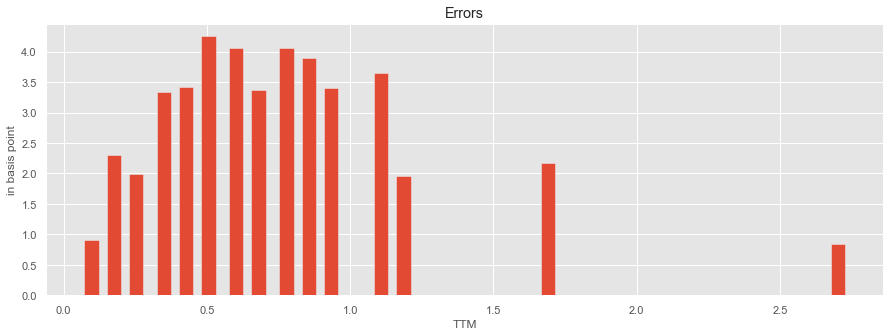

In [128]:
errors = pd.DataFrame(err.values(),index = L.TTM.sort_values().unique(),columns = ['IVMSE'])
vls = pd.DataFrame(Params.values(),index = L.TTM.sort_values().unique(),columns = [r'$H$',r'$\nu$',r'$\rho$',r'$\xi$'])
df = errors.join(vls)
bins,hist=np.histogram(df.IVMSE)
fig = plt.figure(figsize=(15,5))
plt.bar(df.index.tolist(),df.IVMSE * 1e5,0.05,align = 'center')
plt.title('Errors')
plt.xlabel('TTM')
plt.ylabel('in basis point')
plt.show()

In [118]:
#Jfew = (pd.DataFrame(Params.values())).round(3)
#jhhd = (pd.DataFrame(err.values()) * 1e5).round(3)
#jhhd.columns = ['ert']
#A = Jfew.join(jhhd)
#A.index = L.TTM.unique().round(3)
#print(A.to_latex())

# Steps to generate  fBm using Cholesky decomposition

In [130]:
from scipy import linalg
import numba 
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
empty_mt = np.zeros(1024*1024).reshape(1024,1024)
H = 0.1
t1 = np.linspace(1/252,4.0635,1024)
t2 = np.linspace(1/252,4.0635,1024)

In [131]:
%%time
@jit(nopython=True, parallel=True,fastmath=True)
def autocov(t1,t2,empty_mt,n,H):
    for m in range(n):
        l = t2[m] 
        for i in range(n): 
            x = t1[i]
            empty_mt[i,m] = .5 * (x**(2*H) + l**(2*H) - np.abs(x-l)**(2*H))
    return empty_mt

CPU times: user 420 µs, sys: 382 µs, total: 802 µs
Wall time: 810 µs


In [132]:
%%time
df = autocov(t1,t2,empty_mt,len(t2),H)

CPU times: user 252 ms, sys: 10.9 ms, total: 263 ms
Wall time: 262 ms


In [133]:
M = int(3e5)
Lower_mt = linalg.cholesky(df, lower=True)
rnd = np.random.normal(size=(M,len(t1)))
arr = np.ones(M*len(t1)).reshape(M,len(t1))

In [134]:
@jit(nopython=True, parallel=True,fastmath=True)
def Generate_MC(Lower_mt,rnd,M,arr):
    for i in numba.prange(M):
        arr[i,:] = Lower_mt @ rnd[i,:]
    return arr
        

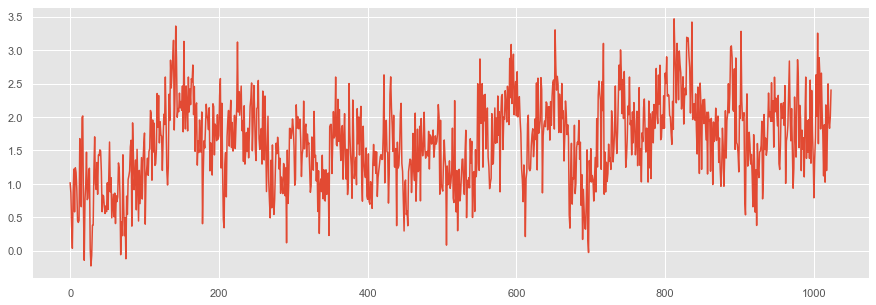

CPU times: user 1.67 s, sys: 897 ms, total: 2.57 s
Wall time: 456 ms


In [139]:
%%time
b = Generate_MC(Lower_mt,rnd,int(1e3),arr)
Lower_mt = linalg.cholesky(df, lower=True)
W_h_t = {} 
for i in range(100):
    W_h_t[i] = np.dot(Lower_mt,np.random.normal(0,1,1024).reshape(1024,1))
fig = plt.figure(figsize=(15,5))
plt.plot(W_h_t[70])
plt.show()

# Using Eigenvalues Decomposition (To be continued)

In [140]:
%%time
from scipy.linalg import circulant,eigvals,eig,inv
from scipy.linalg import toeplitz
def Eigend(H,t1,t2,empty_mt,n):
    df = autocov(t1,t2,empty_mt,n,H)
    first_columns = df[0,:]
    lambd,Q = eig(df)
    M = np.dot(Q,np.diag(np.sqrt(lambd)))
    ZS = np.dot(M,np.random.normal(0,1,size=(n,2))).real
    return ZS

CPU times: user 18 µs, sys: 40 µs, total: 58 µs
Wall time: 62 µs


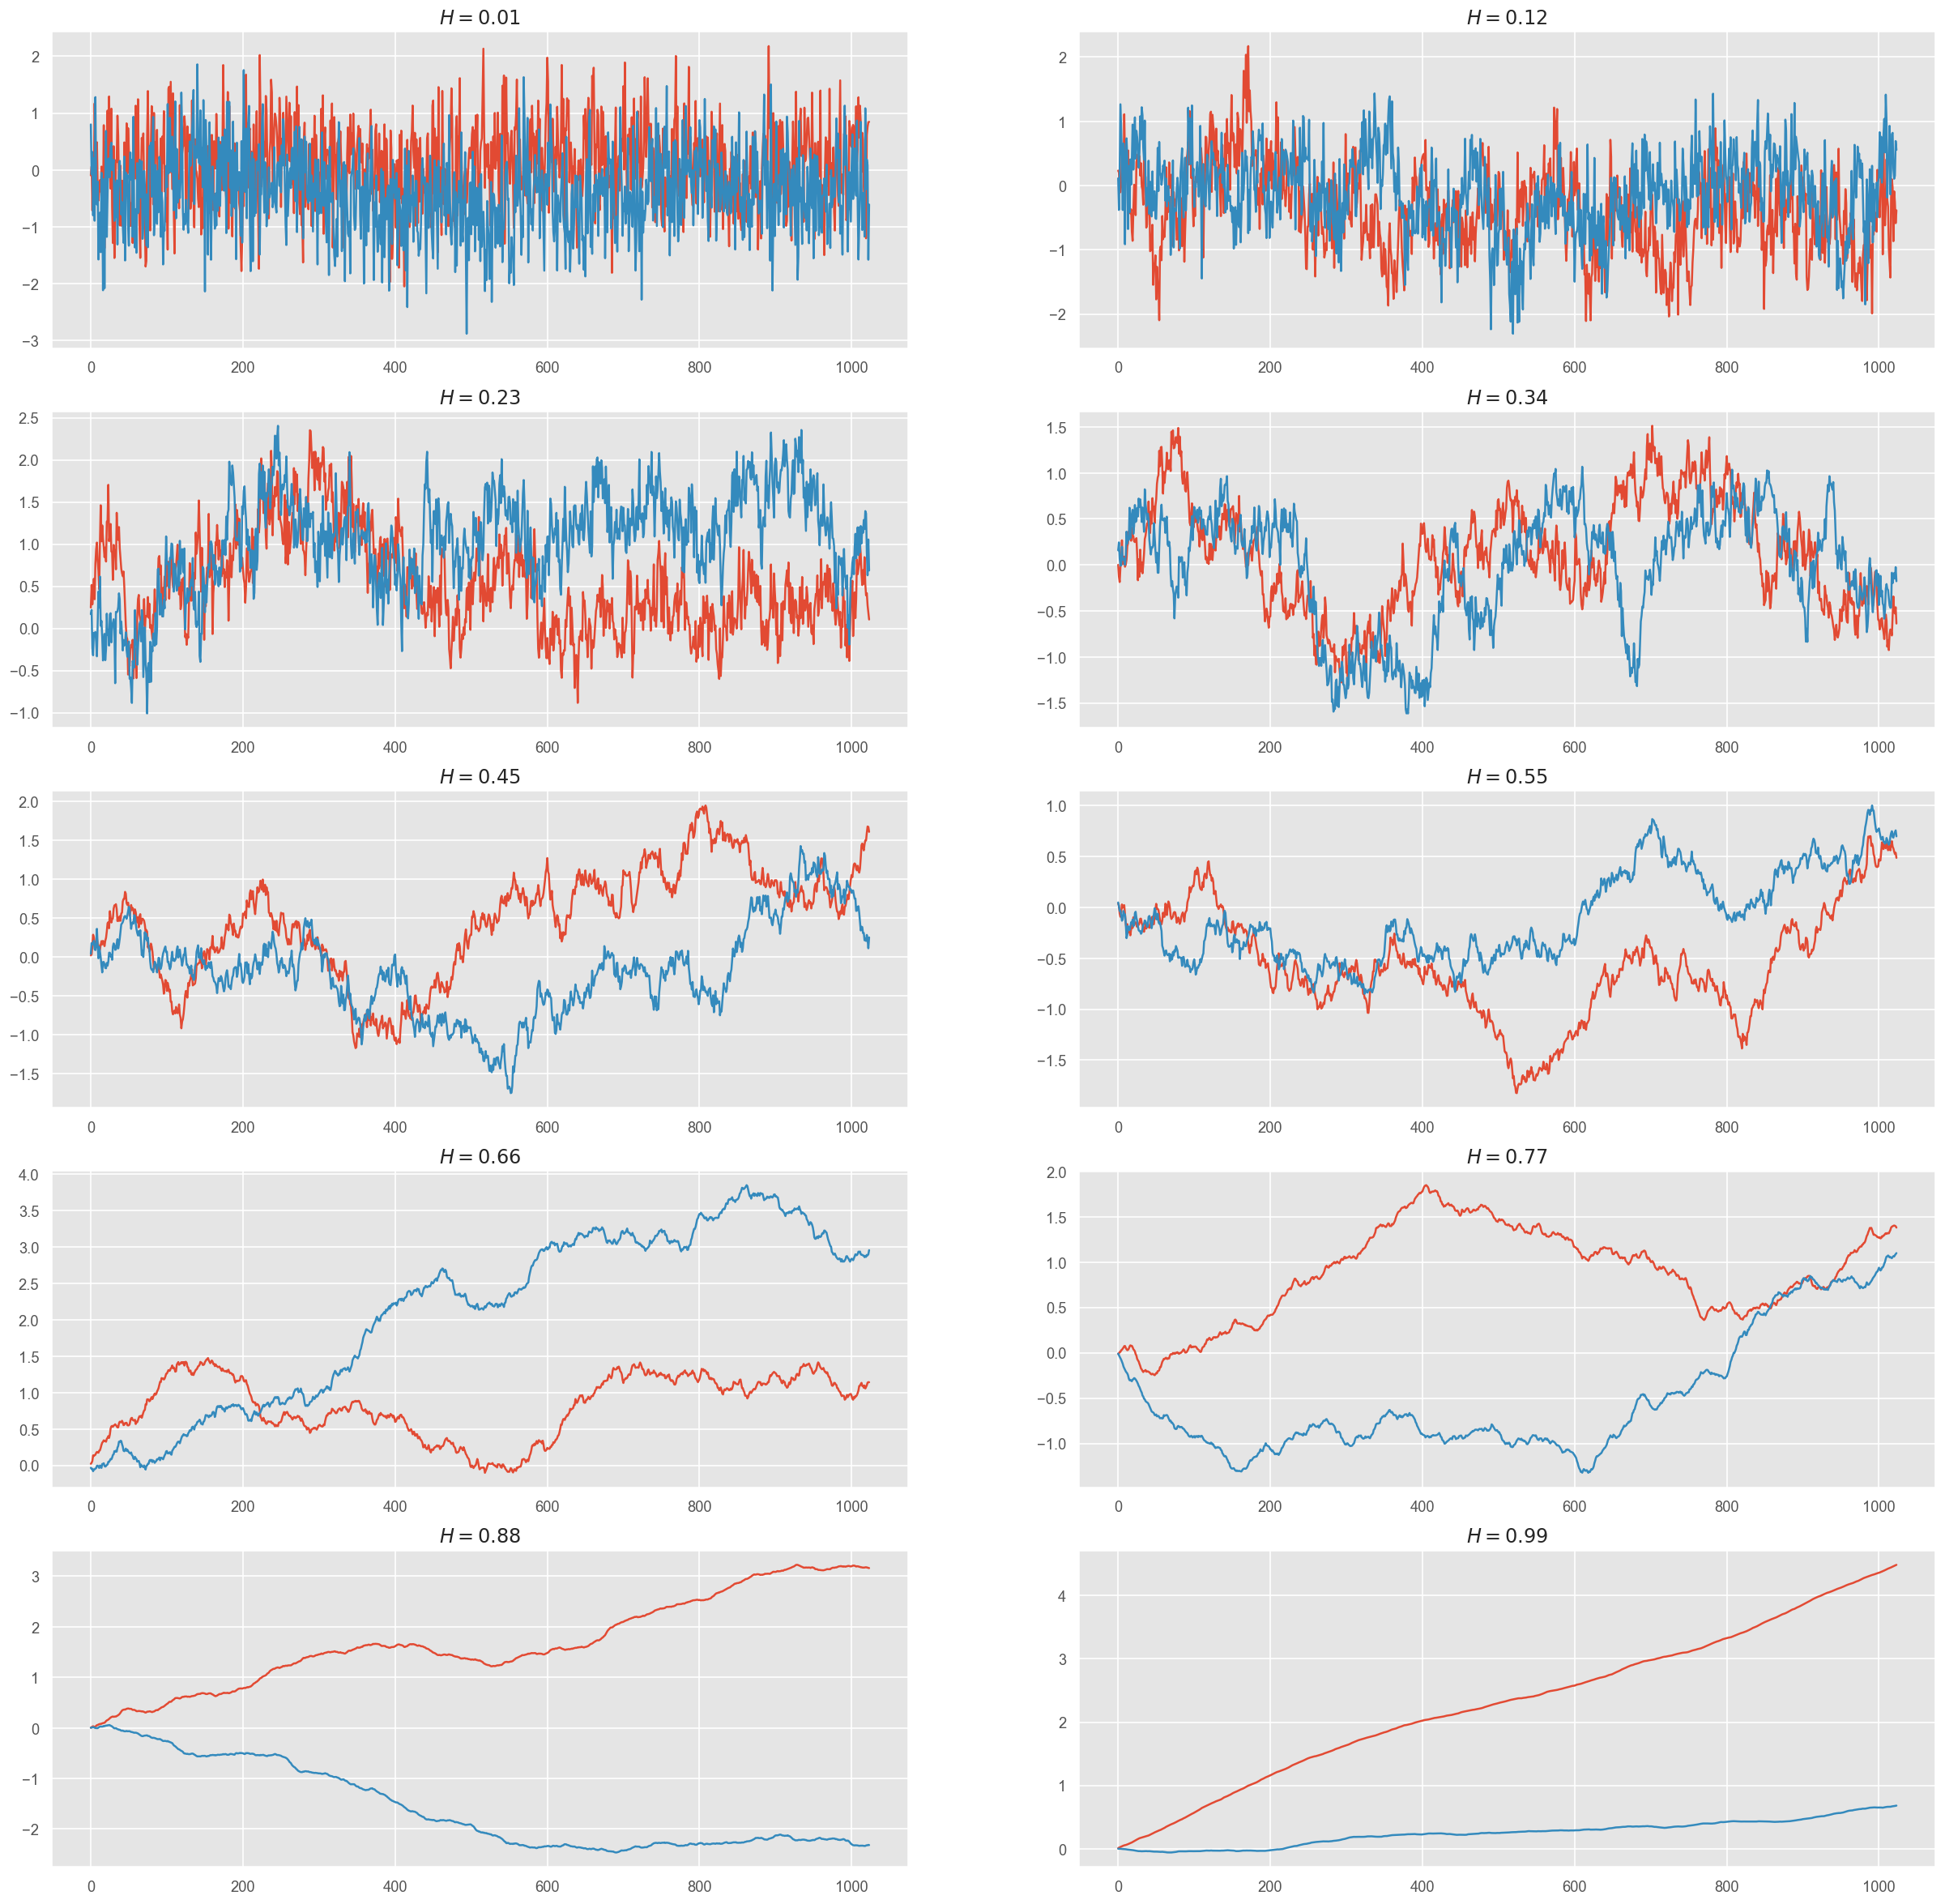

In [141]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(25,25))
K_h = np.linspace(0.01,0.99,10,endpoint=True)

for i, ax in enumerate(axes.flatten()):
    W_H = Eigend(K_h[i],t1,t2,empty_mt,len(t2))
    ax.plot(W_H)
    ax.set_title(r'$H = {}$'.format(np.round(K_h[i],2)))
plt.show()

# Using Eigenvector decomposition with Circulant and DFT matrix 

In [68]:
from scipy.linalg import circulant,eigvals,eig,inv
import numpy as np 
def autocovG(H,n,t):
    empty_mt = np.zeros(2 * (n-1))
    inverse_incremant = n/t
    for m in range(n + 1):
        empty_mt[m] = (np.abs((m-1)/inverse_incremant)**(2*H) - 2 * np.abs(m/inverse_incremant)**(2*H) \
                       + np.abs((m+1)/inverse_incremant)**(2*H))*0.5
    empty_mt[n:] = empty_mt[1:n-1][::-1]
    return empty_mt

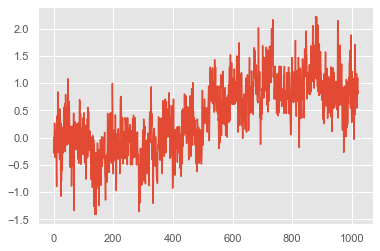

CPU times: user 250 ms, sys: 7.41 ms, total: 257 ms
Wall time: 256 ms


In [146]:
%%time
H = 0.06
n = 2**9
t = n/252
fc = autocovG(H,n,t)
Z = np.random.default_rng().normal(0,1,size=(1,fc.shape[0]))
C = circulant(fc) 
step1 = (np.fft.ifft(np.sqrt(np.fft.fft(fc))*Z, norm='ortho').real)
plt.plot(np.cumsum(step1.T,axis=0))
plt.show()

In [148]:
def fGaussian_Noise_Gen(H,n,t,Z):
    fc = autocovG(H,n,t)
    X = np.sqrt(2)*(np.fft.ifft(np.sqrt(np.fft.fft(fc))*Z, norm='ortho').real)
    return X
    

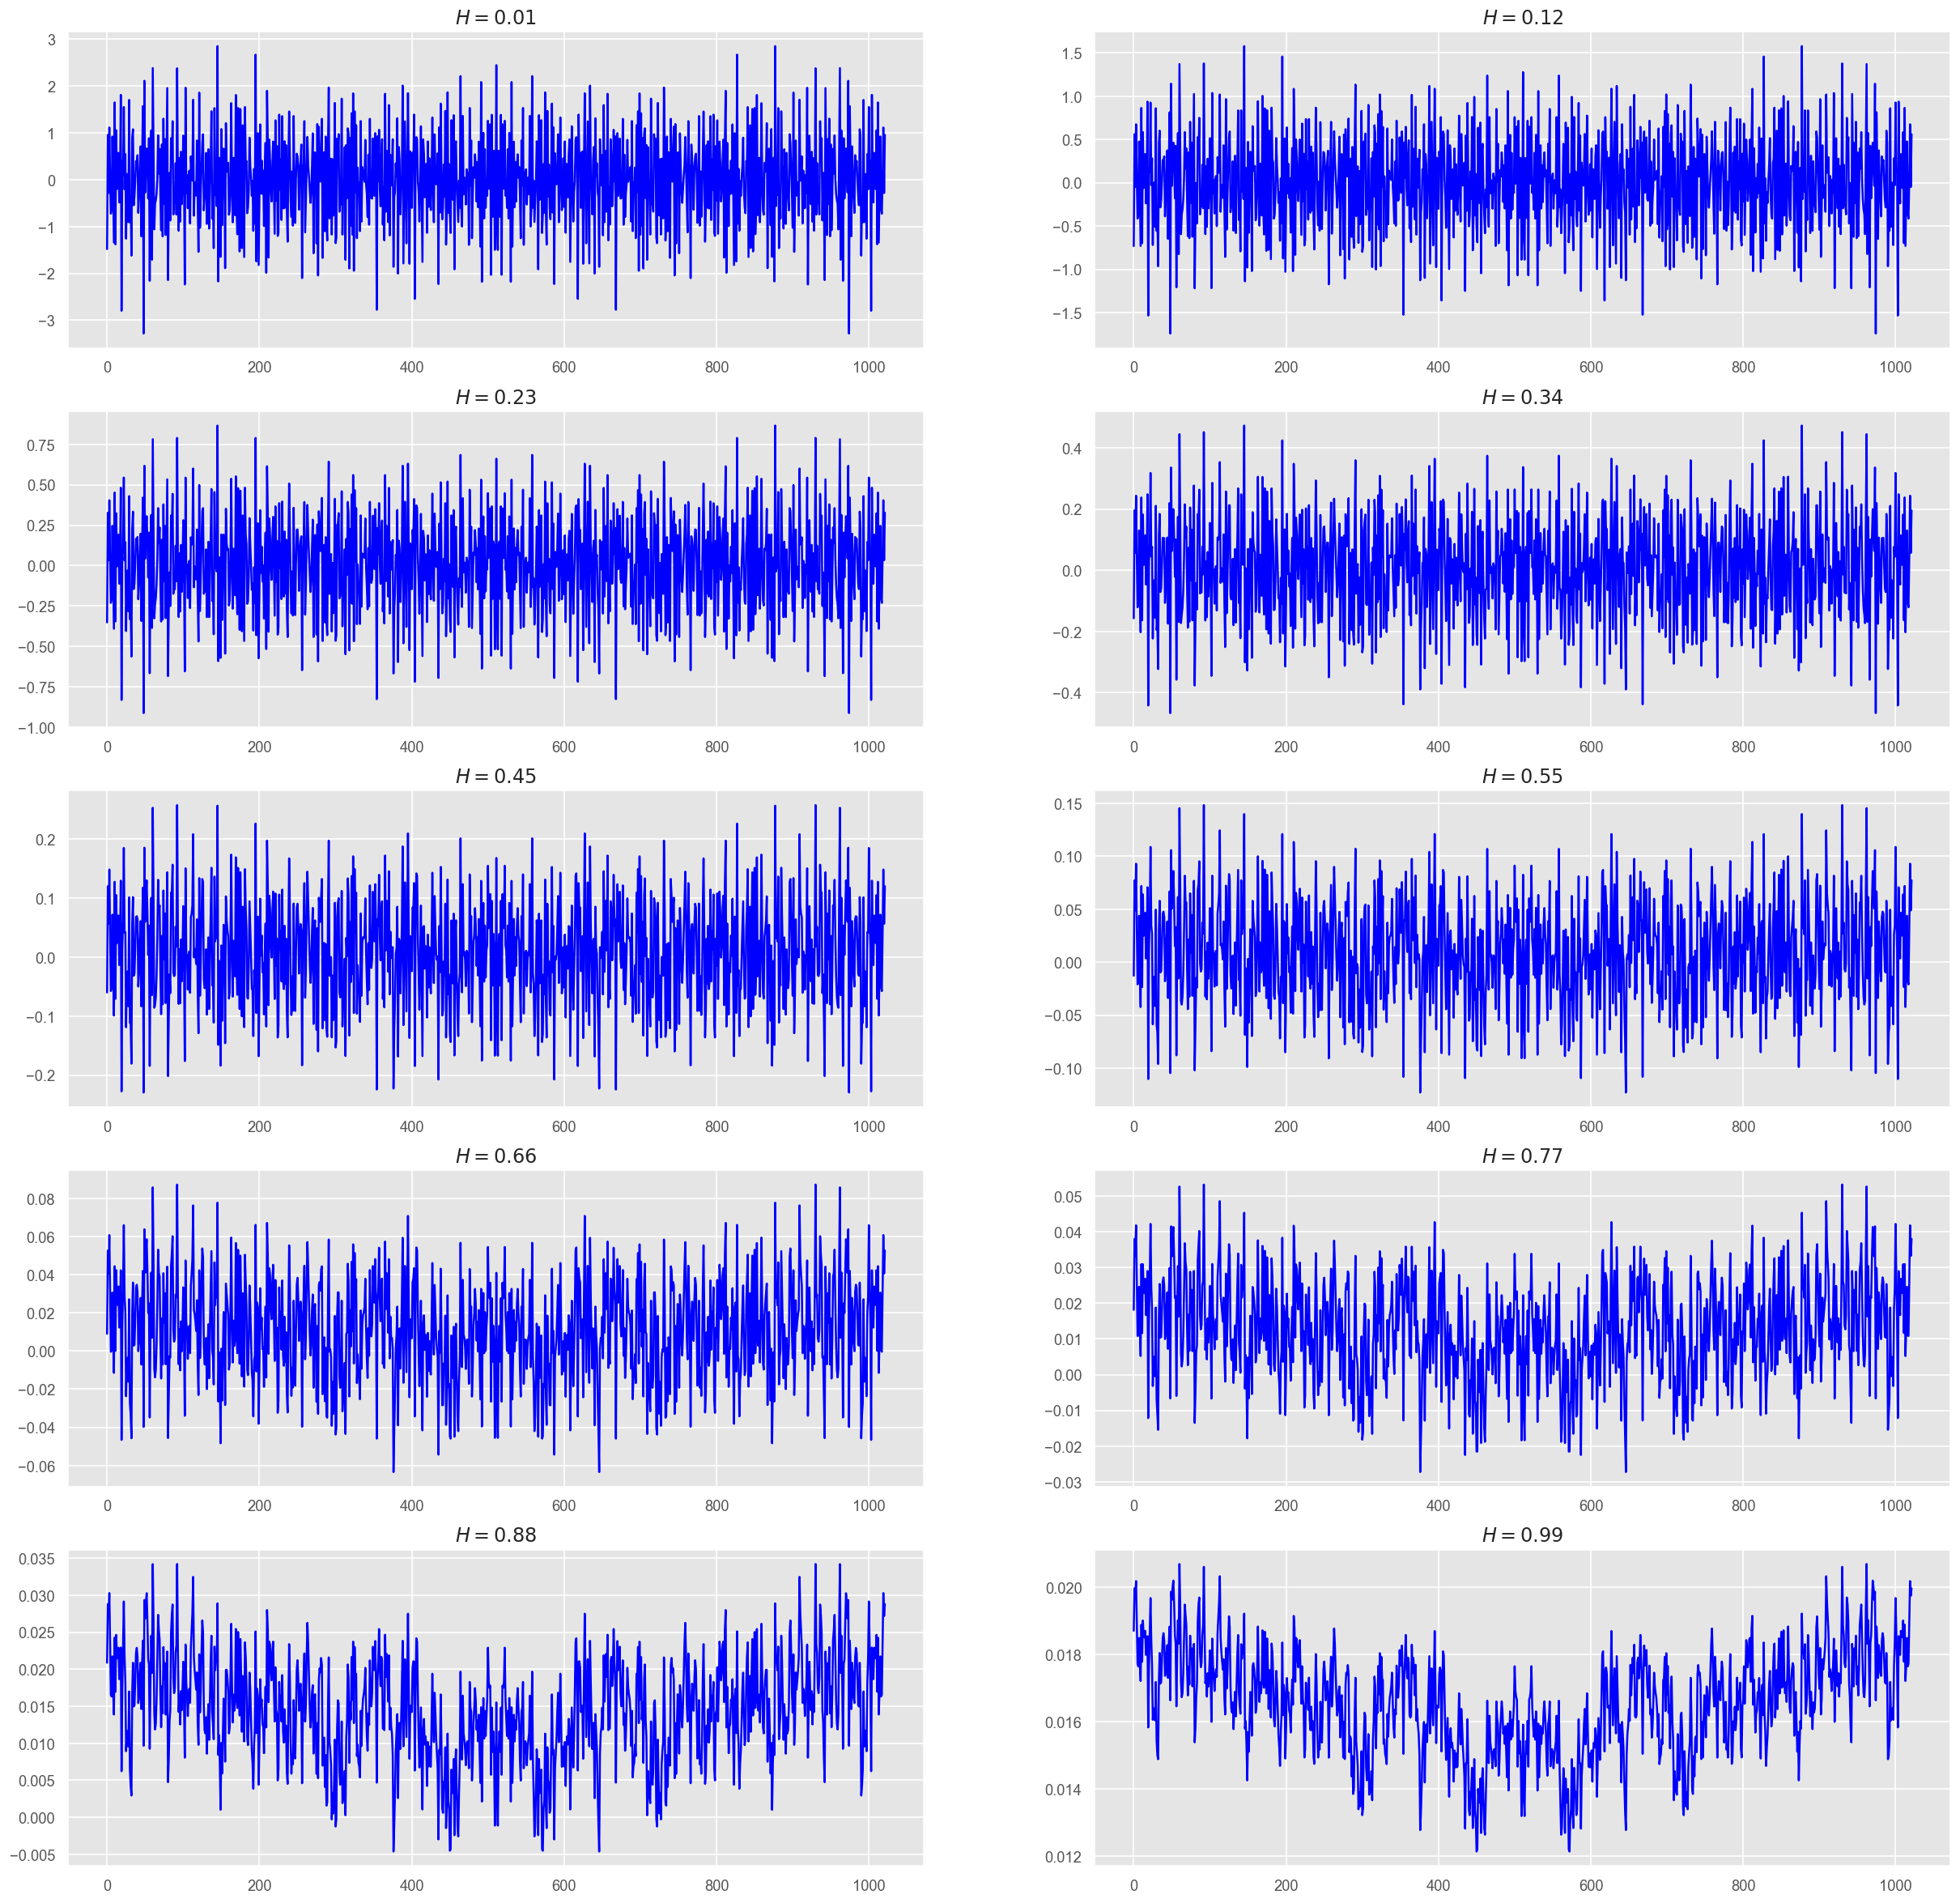

In [149]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(25,25))
K_h = np.linspace(0.01,0.99,10,endpoint=True)
Z = np.random.default_rng().normal(0,1,size=(1,fc.shape[0]))

for i, ax in enumerate(axes.flatten()):
    FGN= fGaussian_Noise_Gen(K_h[i],n,t,Z)[0]
    ax.plot(FGN,color = 'blue')
    ax.set_title(r'$H = {}$'.format(np.round(K_h[i],2)))
plt.show()

In [158]:
%%time
H = 0.50
n = 2**9
t = n / 252
fc = autocovG(H,n,t)
Z = np.random.default_rng().normal(0,1,size=(fc.shape[0],10))
M = np.dot(np.diag(np.sqrt(np.fft.fft(fc))),Z).T
step1_ = np.fft.ifft(M,norm='ortho')
ZS = np.cumsum(step1_.T,axis=0)

CPU times: user 23.3 ms, sys: 20.6 ms, total: 43.9 ms
Wall time: 11.4 ms


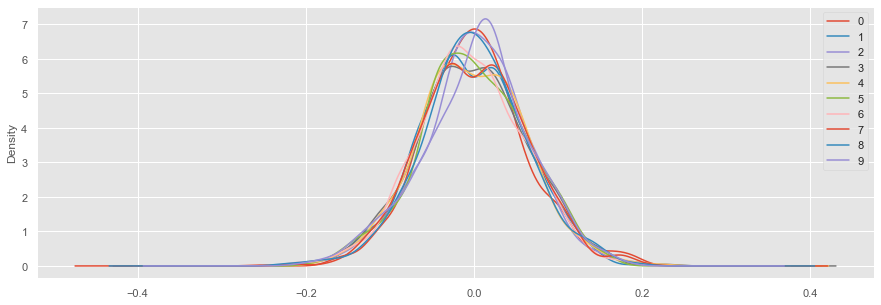

In [154]:
np.random.seed(0)
pd.DataFrame(np.sqrt(2)*step1_.T.real).plot.kde(figsize=(15,5))

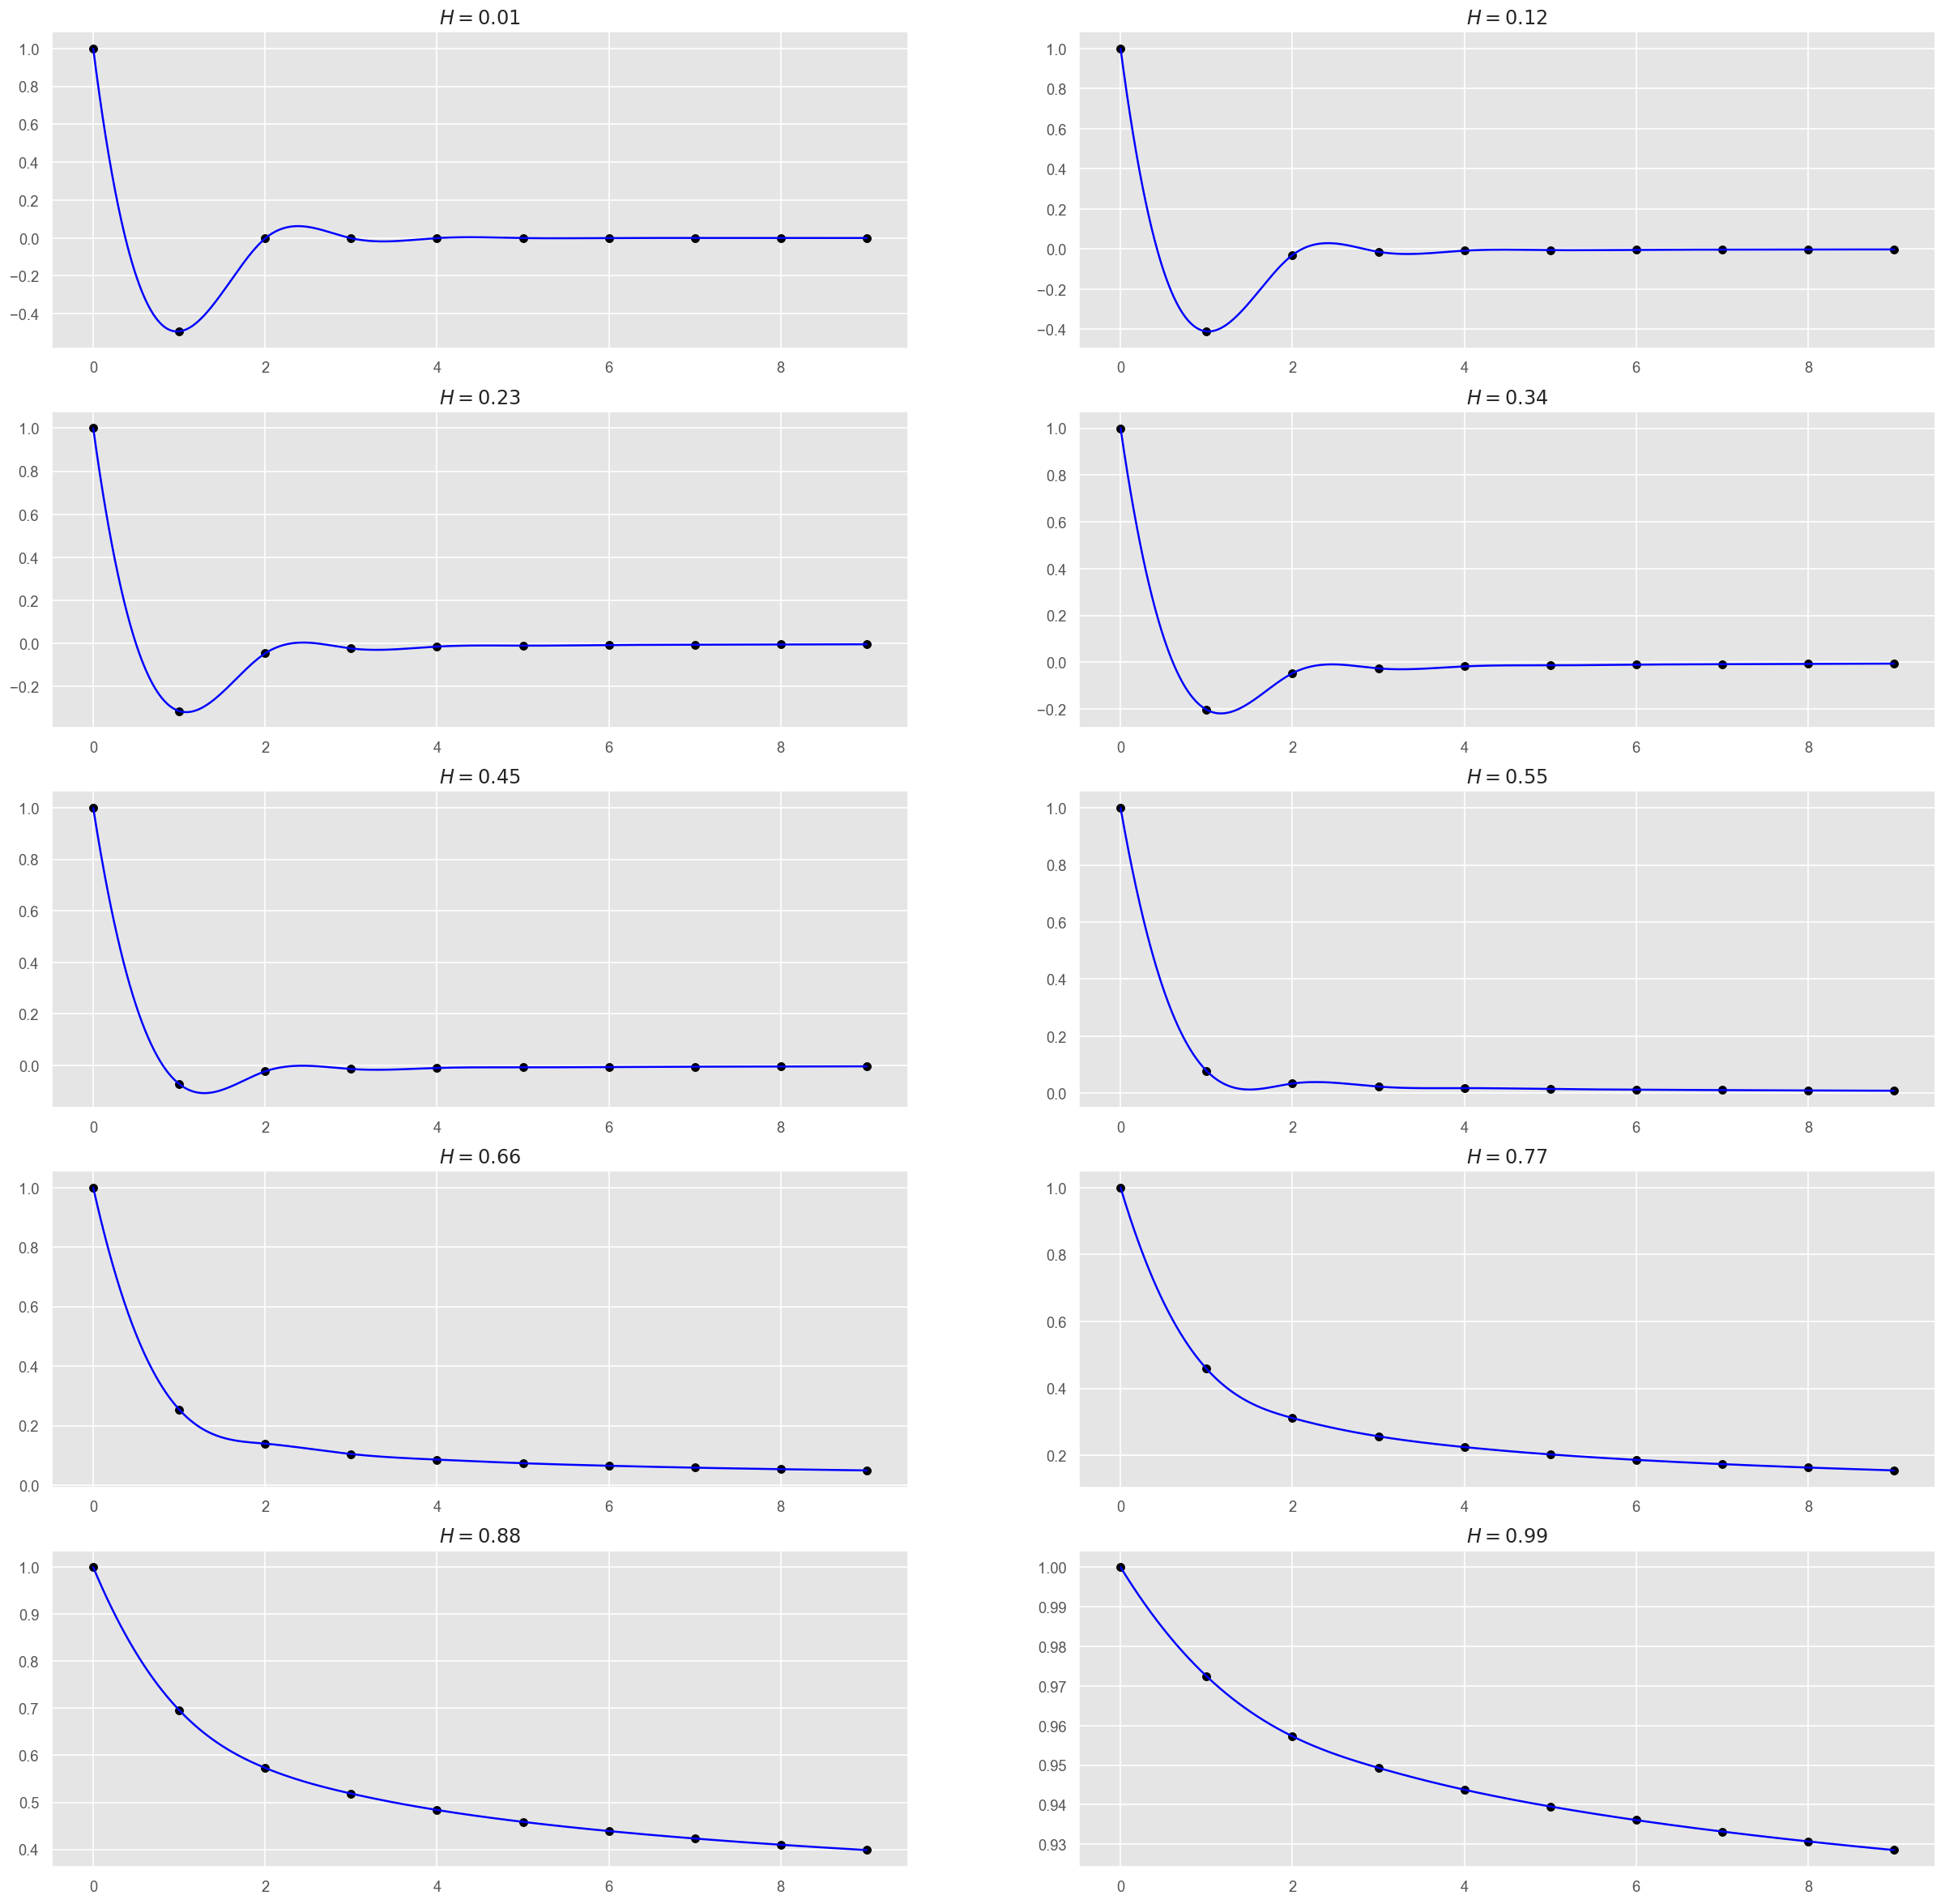

In [156]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(25,25))
K_h = np.linspace(0.01,0.99,10,endpoint=True)

for i, ax in enumerate(axes.flatten()):
    fc = autocovG(K_h[i],n,t)[:10] * (n/t)**(2*K_h[i])
    x = np.arange(10)
    f = interpolate.interp1d(x,fc,kind = 'cubic')
    x_new = np.linspace(0,9,1000)
    y_new = f(x_new)
    ax.plot(x_new,y_new,color = 'blue')
    ax.scatter(x,fc,color = 'black')
    ax.set_title(r'$H = {}$'.format(np.round(K_h[i],2)))
    
plt.show()